# *Merten's Metre* - prosody + interstress intervals

This notebook uses `scansions.json`; conputer-aided scansion suggestions of the *Martijn* trilogy.

We focus on the following research questions:

- RQ1: do witnesses exhibit consistent metrical patterns? Do we find Verdam & Leendertz' insight (b-rhymes = 3 stresses; a-rhymes = 4)?
- RQ2: do witnesses that are close in the stemma show similar metrical characteristics?
- RQ3: are individual scribes consistent in their metrical choices?
- RQ4: how do these patterns compare against texts with paired rhyme schemes (e.g., *Scolastica*)?



In [6]:
# setup and data loading
import json
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

with open('../../data/output/scansions.json', 'r', encoding='utf-8') as f:
    corpus = json.load(f)
print(f"Loaded corpus: {len(corpus)} verse lines")

# mss present?
manuscript_ids = sorted({ms for v in corpus for ms in v['manuscripts'].keys()})
print(f"Manuscripts ({len(manuscript_ids)}): {', '.join(manuscript_ids)}")


Loaded corpus: 1826 verse lines
Manuscripts (18): A, Ant, B, Br, C, D, D2, E, F, G, Ge, H, K, L, O, W, Y, Z


## 1. Corpus exploration

First, let's understand the structure of the Martijn corpus:

- How many parts (M1, M2, M3)?
- How many stanzas per part?
- How many verse lines per part?
- Do all stanzas have 13 lines?



In [7]:
import re

# first, parse verse_line_id metadata: part, stanza, cumulative line, position (1..13)
def parse_verse_id(verse_line_id: str):
    m = re.match(r'^(M[123])_(\d{2})_(\d{3})$', verse_line_id)
    if not m:
        return None
    return {
        'part': m.group(1),
        'stanza': int(m.group(2)),
        'cumulative_line': int(m.group(3))
    }

# parse all verse IDs
verse_metadata = []
for v in corpus:
    meta = parse_verse_id(v['verse_line_id'])
    if meta:
        verse_metadata.append(meta)
    else:
        print(f"Warning: Could not parse verse_id: {v['verse_line_id']}")

df_meta = pd.DataFrame(verse_metadata)

# summary by part
summary_parts = []
for part in ['M1', 'M2', 'M3']:
    part_data = df_meta[df_meta['part'] == part]
    if len(part_data) == 0:
        continue
    
    n_verses = len(part_data)
    n_stanzas = part_data['stanza'].nunique()
    max_stanza = part_data['stanza'].max()
    max_cumulative = part_data['cumulative_line'].max()
    
    # Check line counts per stanza
    lines_per_stanza = part_data.groupby('stanza').size()
    mean_lines = lines_per_stanza.mean()
    min_lines = lines_per_stanza.min()
    max_lines = lines_per_stanza.max()
    stanzas_with_13 = (lines_per_stanza == 13).sum()
    
    summary_parts.append({
        'Part': part,
        'Total verse lines': n_verses,
        'Number of stanzas': n_stanzas,
        'Max stanza number': max_stanza,
        'Max cumulative line': max_cumulative,
        'Mean lines per stanza': f"{mean_lines:.1f}",
        'Min lines per stanza': int(min_lines),
        'Max lines per stanza': int(max_lines),
        'Stanzas with exactly 13 lines': int(stanzas_with_13),
        '% stanzas with 13 lines': f"{100 * stanzas_with_13 / n_stanzas:.1f}%"
    })

summary_df = pd.DataFrame(summary_parts)
print("Corpus Structure Summary:")
print("=" * 80)
print(summary_df.to_string(index=False))

# show distribution of lines per stanza
print("\n\nDistribution of lines per stanza:")
print("=" * 80)
for part in ['M1', 'M2', 'M3']:
    part_data = df_meta[df_meta['part'] == part]
    if len(part_data) > 0:
        lines_dist = part_data.groupby('stanza').size().value_counts().sort_index()
        print(f"\n{part}:")
        for count, freq in lines_dist.items():
            print(f"  {count} lines: {freq} stanzas")


Corpus Structure Summary:
Part  Total verse lines  Number of stanzas  Max stanza number  Max cumulative line Mean lines per stanza  Min lines per stanza  Max lines per stanza  Stanzas with exactly 13 lines % stanzas with 13 lines
  M1                977                 75                 75                  976                  13.0                    13                    14                             73                   97.3%
  M2                340                 26                 26                  339                  13.1                    13                    14                             24                   92.3%
  M3                509                 39                 39                  508                  13.1                    13                    14                             37                   94.9%


Distribution of lines per stanza:

M1:
  13 lines: 73 stanzas
  14 lines: 2 stanzas

M2:
  13 lines: 24 stanzas
  14 lines: 2 stanzas

M3:
  13 lines: 37 st

## 2. Manuscript-Level Coverage Analysis

Now let's see which manuscripts have which verses:
- Total verses per manuscript
- Coverage by part (M1/M2/M3) per manuscript
- Which manuscripts have complete vs partial coverage?
- Which verses are present in which manuscripts?



In [8]:
# Analyze manuscript coverage
ms_coverage = []

for ms in manuscript_ids:
    # Count verses per manuscript
    verses_present = []
    for v in corpus:
        if ms in v['manuscripts'] and v['manuscripts'][ms].get('present', False):
            meta = parse_verse_id(v['verse_line_id'])
            if meta:
                verses_present.append(meta)
    
    if len(verses_present) == 0:
        continue
    
    df_ms = pd.DataFrame(verses_present)
    
    # Coverage by part
    coverage_by_part = {}
    for part in ['M1', 'M2', 'M3']:
        part_total = len(df_meta[df_meta['part'] == part])
        part_in_ms = len(df_ms[df_ms['part'] == part])
        coverage_by_part[part] = {
            'present': part_in_ms,
            'total': part_total,
            'pct': 100 * part_in_ms / part_total if part_total > 0 else 0
        }
    
    ms_coverage.append({
        'Manuscript': ms,
        'Total verses': len(verses_present),
        'M1 verses': coverage_by_part['M1']['present'],
        'M1 %': f"{coverage_by_part['M1']['pct']:.1f}%",
        'M2 verses': coverage_by_part['M2']['present'],
        'M2 %': f"{coverage_by_part['M2']['pct']:.1f}%",
        'M3 verses': coverage_by_part['M3']['present'],
        'M3 %': f"{coverage_by_part['M3']['pct']:.1f}%",
    })

coverage_df = pd.DataFrame(ms_coverage).sort_values('Total verses', ascending=False)
print("Manuscript Coverage Summary:")
print("=" * 100)
print(coverage_df.to_string(index=False))


Manuscript Coverage Summary:
Manuscript  Total verses  M1 verses  M1 %  M2 verses   M2 %  M3 verses  M3 %
         O          1821        975 99.8%        340 100.0%        506 99.4%
         F          1821        975 99.8%        339  99.7%        507 99.6%
         B          1816        970 99.3%        338  99.4%        508 99.8%
         D          1811        976 99.9%        339  99.7%        496 97.4%
         G          1770        924 94.6%        338  99.4%        508 99.8%
         A          1767        971 99.4%        339  99.7%        457 89.8%
         C          1472        976 99.9%          0   0.0%        496 97.4%
         L           682        423 43.3%         98  28.8%        161 31.6%
         H           605        349 35.7%        256  75.3%          0  0.0%
        Br           602        303 31.0%        248  72.9%         51 10.0%
         Z           534        266 27.2%        130  38.2%        138 27.1%
         W           508          0  0.0%      

## 3. Prosodic and Interstress Interval Encodings

We extract two types of metrical encodings that capture different aspects of rhythmic variation across manuscripts. We illustrate this with a concrete example from verse **M1_43_556** across five manuscripts:

### Example: Verse M1_43_556

| Manuscript | Text | Stress Pattern | Syllables | Beats |
|------------|------|---------------|-----------|-------|
| A | "mi dincke dat edelheit began" | [0,1,0,0,1,0,1,0,1] | 9 | 4 |
| B | "mi dincke dat eydelhede began" | [0,1,0,0,1,0,1,0,0,1] | 10 | 4 |
| Br | "mi dunct dat edelheit began" | [0,1,0,1,0,1,0,1] | 8 | 4 |
| C | "mi dunct edelheit began" | [0,0,1,0,1,0,1] | 7 | 3 |
| D | "my dunct dat edelheyt began" | [0,1,0,1,0,1,0,1] | 8 | 4 |

### Encoding 1: Prosodic

**Format**: String of `w` (unstressed/weak) and `S` (stressed/strong) syllables. We convert the binary stress pattern `[0,1,0,0,1,...]` directly to `wSww...`

**Example encodings for `M1_43_556`**:
- A: `[0,1,0,0,1,0,1,0,1]` → `"wSwwSwSwS"` (9 syllables, 4 beats)
- B: `[0,1,0,0,1,0,1,0,0,1]` → `"wSwwSwSwwS"` (10 syllables, 4 beats)
- Br: `[0,1,0,1,0,1,0,1]` → `"wSwSwSwS"` (8 syllables, 4 beats)
- C: `[0,0,1,0,1,0,1]` → `"wwSwSwS"` (7 syllables, 3 beats)
- D: `[0,1,0,1,0,1,0,1]` → `"wSwSwSwS"` (8 syllables, 4 beats)

This encoding captures the **rhythmic contour** of stress placement independent of lexical content/word boundaries. Allows us to extract n-grams (e.g., `"wS"`, `"Sw"`, `"wSw"`) that characterize scribal prosodic preferences.

### Encoding 2: Interstress Intervals

**Format**: List of integers representing gaps between (and around) stressed syllables

**How it works**: 
1. **Anacrusis** (first value): count unstressed syllables before the first beat
2. **Internal gaps**: count unstressed syllables between consecutive beats
3. **Clausula** (last value): count unstressed syllables after the final beat

**Example encodings for M1_43_556**:
- A: `[0,1,0,0,1,0,1,0,1]` → Intervals `[1, 2, 1, 1]`
  - `1` = anacrusis (one `w` before first `S`)
  - `2` = gap between beats 1-2 (two `w` between first and second `S`)
  - `1` = gap between beats 2-3 (one `w` between second and third `S`)
  - `1` = clausula (one `w` after final `S`)
- B: `[0,1,0,0,1,0,1,0,0,1]` → Intervals `[1, 2, 1, 2]`
  - Same pattern as A, but clausula = 2 (two `w` after final `S`)
- Br: `[0,1,0,1,0,1,0,1]` → Intervals `[1, 1, 1, 1]`
  - Regular pattern: all gaps = 1 (tight rhythm throughout)
- C: `[0,0,1,0,1,0,1]` → Intervals `[2, 1, 1]`
  - Only 3 beats: anacrusis = 2, then two gaps of 1
- D: `[0,1,0,1,0,1,0,1]` → Intervals `[1, 1, 1, 1]`
  - Identical to Br: regular tight rhythm

This encoding captures **rhythmic spacing/tightness** between beats. Allows us to investigate whether scribes prefer regular intervals (many `1`s = tight, predictable rhythm) or variable intervals (mix of `1`s, `2`s, `3`s = loose, flexible rhythm).


### Encoding 3: Interval-by-Ictus Position Vector

**Format**: List of tuples `[(ictus_idx, interval_value), ...]` where `ictus_idx` indicates position

**How it works**:
- `ictus_idx = 0`: anacrusis (gap before first beat)
- `ictus_idx = 1..n-2`: gaps between consecutive beats
- `ictus_idx = n-1`: clausula (gap after final beat)

**Example encodings for M1_43_556**:
- A: Intervals `[1, 2, 1, 1]` → Vector `[(0,1), (1,2), (2,1), (3,1)]`
- Br: Intervals `[1, 1, 1, 1]` → Vector `[(0,1), (1,1), (2,1), (3,1)]`

This encoding preserves **positional context**. Allows us to ask: "Do scribes prefer tight intervals at the beginning but loose ones at the end?" or "Is there a pattern in how intervals vary by ictus position?"


In [9]:
# helper functions for encoding extraction

def extract_stress_sequence(ms_scansion):
    """Extract binary stress sequence from scansion data."""
    if not ms_scansion:
        return []
    return [s['stress'] for token in ms_scansion['scanned'] for s in token['syllables']]


def prosodic_stress_only(ms_scansion):
    """Extract stress-only prosodic encoding (w/S string, no boundaries)."""
    if not ms_scansion:
        return None
    stresses = extract_stress_sequence(ms_scansion)
    return ''.join('S' if x == 1 else 'w' for x in stresses)


def prosodic_marked(ms_scansion):
    """Boundary-aware prosodic encoding with line/word markers.
    Output uses: '#' = line start, 'w'/'S' per syllable, '.' = word boundary, '|' = line end.
    Example: #wS.w.|  (start, syllables with boundaries, end)
    """
    if not ms_scansion:
        return None
    parts = ['#']
    for token in ms_scansion.get('scanned', []):
        sylls = token.get('syllables', [])
        if not sylls:
            continue
        for s in sylls:
            parts.append('S' if s.get('stress', 0) == 1 else 'w')
        parts.append('.')  # word boundary after each token with syllables
    # Replace the last '.' with '|', or append '|' if none
    if parts and parts[-1] == '.':
        parts[-1] = '|'
    else:
        parts.append('|')
    return ''.join(parts)


def extract_interstress_intervals(stress_sequence):
    """
    Extract interstress intervals: anacrusis, gaps between beats, clausula.
    Returns list of integers.
    """
    if not stress_sequence:
        return []
    intervals = []
    gap = 0
    for s in stress_sequence:
        if s == 1:  # Stressed syllable (beat)
            intervals.append(gap)
            gap = 0
        else:  # Unstressed syllable
            gap += 1
    # Add clausula (final gap after last beat)
    if gap > 0:
        intervals.append(gap)
    return intervals


def interval_by_ictus_vector(intervals):
    """
    Create interval-by-ictus-position vector.
    Returns list of tuples: [(ictus_idx, interval_value), ...]
    where ictus_idx 0 = anacrusis, 1..n-2 = gaps between beats, n-1 = clausula
    """
    if not intervals:
        return []
    return [(idx, val) for idx, val in enumerate(intervals)]


def beat_count(stress_sequence):
    """Count number of stressed syllables (beats) in a line."""
    return sum(1 for s in stress_sequence if s == 1)


def cadence_type(stress_sequence):
    """
    determine cadence based on final syllable:
    - Masculine: line ends with stressed syllable (final syllable is stressed)
    - Feminine: line ends with unstressed syllable (final syllable is unstressed)
    """
    if not stress_sequence:
        return None
    # Check the last syllable in the stress sequence
    return 'masculine' if stress_sequence[-1] == 1 else 'feminine'


# Extract encodings for all verses and manuscripts
encoding_rows = []

for v in corpus:
    meta = parse_verse_id(v['verse_line_id'])
    if not meta:
        continue
    
    for ms, ms_data in v['manuscripts'].items():
        if not ms_data.get('present', False) or 'scansion' not in ms_data:
            continue
        
        sc = ms_data['scansion']
        stresses = extract_stress_sequence(sc)
        intervals = extract_interstress_intervals(stresses)
        prosody = prosodic_stress_only(sc)
        prosody_bounded = prosodic_marked(sc)
        ictus_vector = interval_by_ictus_vector(intervals)
        
        encoding_rows.append({
            'verse_id': v['verse_line_id'],
            'part': meta['part'],
            'stanza': meta['stanza'],
            'cumulative_line': meta['cumulative_line'],
            'ms': ms,
            'text': ms_data.get('text'),  # Actual line text for this manuscript
            'prosody': prosody,
            'prosody_marked': prosody_bounded,
            'intervals': intervals,
            'interval_str': '-'.join(map(str, intervals)),  # For easier display
            'ictus_vector': ictus_vector,  # List of (ictus_idx, interval_value) tuples
            'beats': beat_count(stresses),
            'cadence': cadence_type(stresses),  # 'masculine' or 'feminine'
            'n_syllables': len(stresses)
        })

encodings_df = pd.DataFrame(encoding_rows)

# Compute line number within stanza (1-based position within each stanza)
# For each unique verse, compute its position within its stanza
# (cumulative_line resets or we can compute from the order of verses within each stanza)
verse_stanza_line = {}
for (part, stanza), group in encodings_df.groupby(['part', 'stanza']):
    # Get unique verses in this stanza, sorted by cumulative_line
    unique_verses = group[['verse_id', 'cumulative_line']].drop_duplicates().sort_values('cumulative_line')
    for idx, (_, row) in enumerate(unique_verses.iterrows(), 1):
        verse_stanza_line[row['verse_id']] = idx

encodings_df['stanza_line'] = encodings_df['verse_id'].map(verse_stanza_line)

column_order = [
    'verse_id', 'part', 'stanza', 'stanza_line',  # Verse identification
    'ms',  # Manuscript
    'text',  # Text content
    'prosody', 'prosody_marked',  # Prosodic encodings
    'intervals', 'interval_str', 'ictus_vector',  # Interval encodings
    'beats', 'cadence', 'n_syllables',  # Derived metrics
    'cumulative_line'  # Auxiliary
]
encodings_df = encodings_df[column_order]

print(f"Extracted encodings: {len(encodings_df)} verse-manuscript combinations")
print(f"Unique verses: {encodings_df['verse_id'].nunique()}")
print(f"Unique manuscripts: {encodings_df['ms'].nunique()}")
print(f"\nSample encodings:")
encodings_df


Extracted encodings: 16354 verse-manuscript combinations
Unique verses: 1826
Unique manuscripts: 18

Sample encodings:


,verse_id,part,stanza,stanza_line,ms,text,prosody,prosody_marked,intervals,interval_str,ictus_vector,beats,cadence,n_syllables,cumulative_line
0,M1_01_000,M1,1,1,C,van iacob ende van martijn.,wSwSwSwS,#w.Sw.Sw.S.wS|,"[1, 1, 1, 1]",1-1-1-1,"[(0, 1), (1, 1), (2, 1), (3, 1)]",4,masculine,8,0
1,M1_01_000,M1,1,1,D,¶ dit is wapene martijn,SwSwSwS,#S.w.SwS.wS|,"[0, 1, 1, 1]",0-1-1-1,"[(0, 0), (1, 1), (2, 1), (3, 1)]",4,masculine,7,0
2,M1_01_000,M1,1,1,G,dit es dierste boec vanden wapen merten,wwSwwSwSwSw,#w.w.Sw.w.Sw.Sw.Sw|,"[2, 2, 1, 1, 1]",2-2-1-1-1,"[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1)]",4,feminine,11,0
3,M1_01_001,M1,1,2,A,vvaphene martin hoe salt gaen,SSwwSwwS,#SSw.wS.w.w.S|,"[0, 0, 2, 2]",0-0-2-2,"[(0, 0), (1, 0), (2, 2), (3, 2)]",4,masculine,8,1
4,M1_01_001,M1,1,2,B,waphene martin hoe salt gaen,wSwwSwwS,#wSw.wS.w.w.S|,"[1, 2, 2]",1-2-2,"[(0, 1), (1, 2), (2, 2)]",3,masculine,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16349,M3_39_508,M3,39,14,F,¶ amen.,Sw,#Sw|,"[0, 1]",0-1,"[(0, 0), (1, 1)]",1,feminine,2,508
16350,M3_39_508,M3,39,14,G,amen:,Sw,#Sw|,"[0, 1]",0-1,"[(0, 0), (1, 1)]",1,feminine,2,508
16351,M3_39_508,M3,39,14,L,amen,Sw,#Sw|,"[0, 1]",0-1,"[(0, 0), (1, 1)]",1,feminine,2,508
16352,M3_39_508,M3,39,14,O,explicit. deo gras.,SwSwwS,#SwS.ww.S|,"[0, 1, 2]",0-1-2,"[(0, 0), (1, 1), (2, 2)]",3,masculine,6,508


## 4. RQ1: Testing Verdam & Leendertz constraints

**Research Question**: Do manuscript witnesses exhibit consistent metrical patterns matching the constraints described by Verdam & Leendertz (1918)?

**The Constraints** (Verdam & Leendertz 1918):

Verdam & Leendertz identified two metrical constraints in the Martijn Trilogy's 13-line stanza structure (rhyme scheme AAB/AAB/AAB/AABB):

1. **Beat count constraint** (constant across all parts):
   - **A-rhyme lines** (positions 1,2,4,5,7,8,10,11): 4 beats
   - **B-rhyme lines** (positions 3,6,9,12,13): 3 beats

2. **Cadence constraint** (varies by part):
   - **M1/M2**: A-rhymes = masculine rhyme type, B-rhymes = feminine rhyme type
   - **M3**: A-rhymes = feminine rhyme type, B-rhymes = masculine rhyme type (pattern reversed)

What we'll do to test this:

1. Filter corpus to complete 13-line stanzas with 3-4 beat lines
2. Test each constraint independently:
   - Beat constraint: Does beat count match rhyme position expectation?
   - Rhyme type constraint: Does rhyme type match part-specific rhyme position expectation?
3. Analyze adherence rates by part, position, and manuscript

In [10]:
# Filter to 13-line stanzas with 3-4 beat lines
stanza_lengths = encodings_df.groupby(['part', 'stanza'])['stanza_line'].max()
valid_stanzas = stanza_lengths[stanza_lengths == 13].index
rq1_df = encodings_df[encodings_df.set_index(['part', 'stanza']).index.isin(valid_stanzas)].copy()

print(f"Filtered to 13-line stanzas: {len(rq1_df)} lines from {len(valid_stanzas)} stanzas")

# filter to 3-4 beat lines
rq1_df = rq1_df[rq1_df['beats'].isin([3, 4])].copy()

print(f"Filtered to 3-4 beat lines: {len(rq1_df)} lines")

# lines with rhyme positions based on AAB/AAB/AAB/AABB pattern
rhyme_A = {1, 2, 4, 5, 7, 8, 10, 11}  # A-rhyme lines
rhyme_B = {3, 6, 9, 12, 13}           # B-rhyme lines

# Label rhyme type
rq1_df['rhyme_type'] = rq1_df['stanza_line'].apply(
    lambda x: 'A' if x in rhyme_A else 'B'
)

# Test Constraint 1: Beat count by rhyme type
def matches_beat_constraint(row):
    """Test if beat count matches rhyme-based expectation."""
    if row['rhyme_type'] == 'A':
        return row['beats'] == 4
    else:  # rhyme_type == 'B'
        return row['beats'] == 3

rq1_df['matches_beat_constraint'] = rq1_df.apply(matches_beat_constraint, axis=1)

# Test Constraint 2: Rhyme type (masculine/feminine) by rhyme position and part
def matches_rhyme_type_constraint(row):
    """Test if rhyme type (masculine/feminine) matches part-specific expectation."""
    part = row['part']
    rhyme = row['rhyme_type']  # A or B based on position
    cadence = row['cadence']  # 'masculine' or 'feminine'
    
    if part in ['M1', 'M2']:
        if rhyme == 'A':
            return cadence == 'masculine'
        else:  # rhyme == 'B'
            return cadence == 'feminine'
    elif part == 'M3':
        if rhyme == 'A':
            return cadence == 'feminine'
        else:  # rhyme == 'B'
            return cadence == 'masculine'
    
    return False

rq1_df['matches_rhyme_type_constraint'] = rq1_df.apply(matches_rhyme_type_constraint, axis=1)

# Test both constraints together
rq1_df['matches_both'] = rq1_df['matches_beat_constraint'] & rq1_df['matches_rhyme_type_constraint']

# Summary statistics
print("\nOverall constraint compliance:")
print(f"  Beat constraint:       {rq1_df['matches_beat_constraint'].mean():.1%}")
print(f"  Rhyme type constraint:  {rq1_df['matches_rhyme_type_constraint'].mean():.1%}")
print(f"  Both constraints:       {rq1_df['matches_both'].mean():.1%}")

print("\nComliance to template by Martijn-part:")
for part in ['M1', 'M2', 'M3']:
    part_df = rq1_df[rq1_df['part'] == part]
    print(f"  {part}:")
    print(f"    Beat:       {part_df['matches_beat_constraint'].mean():.1%}")
    print(f"    Rhyme type: {part_df['matches_rhyme_type_constraint'].mean():.1%}")
    print(f"    Both:       {part_df['matches_both'].mean():.1%}")

Filtered to 13-line stanzas: 15559 lines from 134 stanzas
Filtered to 3-4 beat lines: 14519 lines

Overall constraint compliance:
  Beat constraint:       77.5%
  Rhyme type constraint:  98.2%
  Both constraints:       76.5%

Comliance to template by Martijn-part:
  M1:
    Beat:       79.0%
    Rhyme type: 98.3%
    Both:       78.1%
  M2:
    Beat:       77.7%
    Rhyme type: 98.0%
    Both:       76.8%
  M3:
    Beat:       74.4%
    Rhyme type: 98.0%
    Both:       73.2%



HEATMAPS: Metrical Patterns by Position and Part


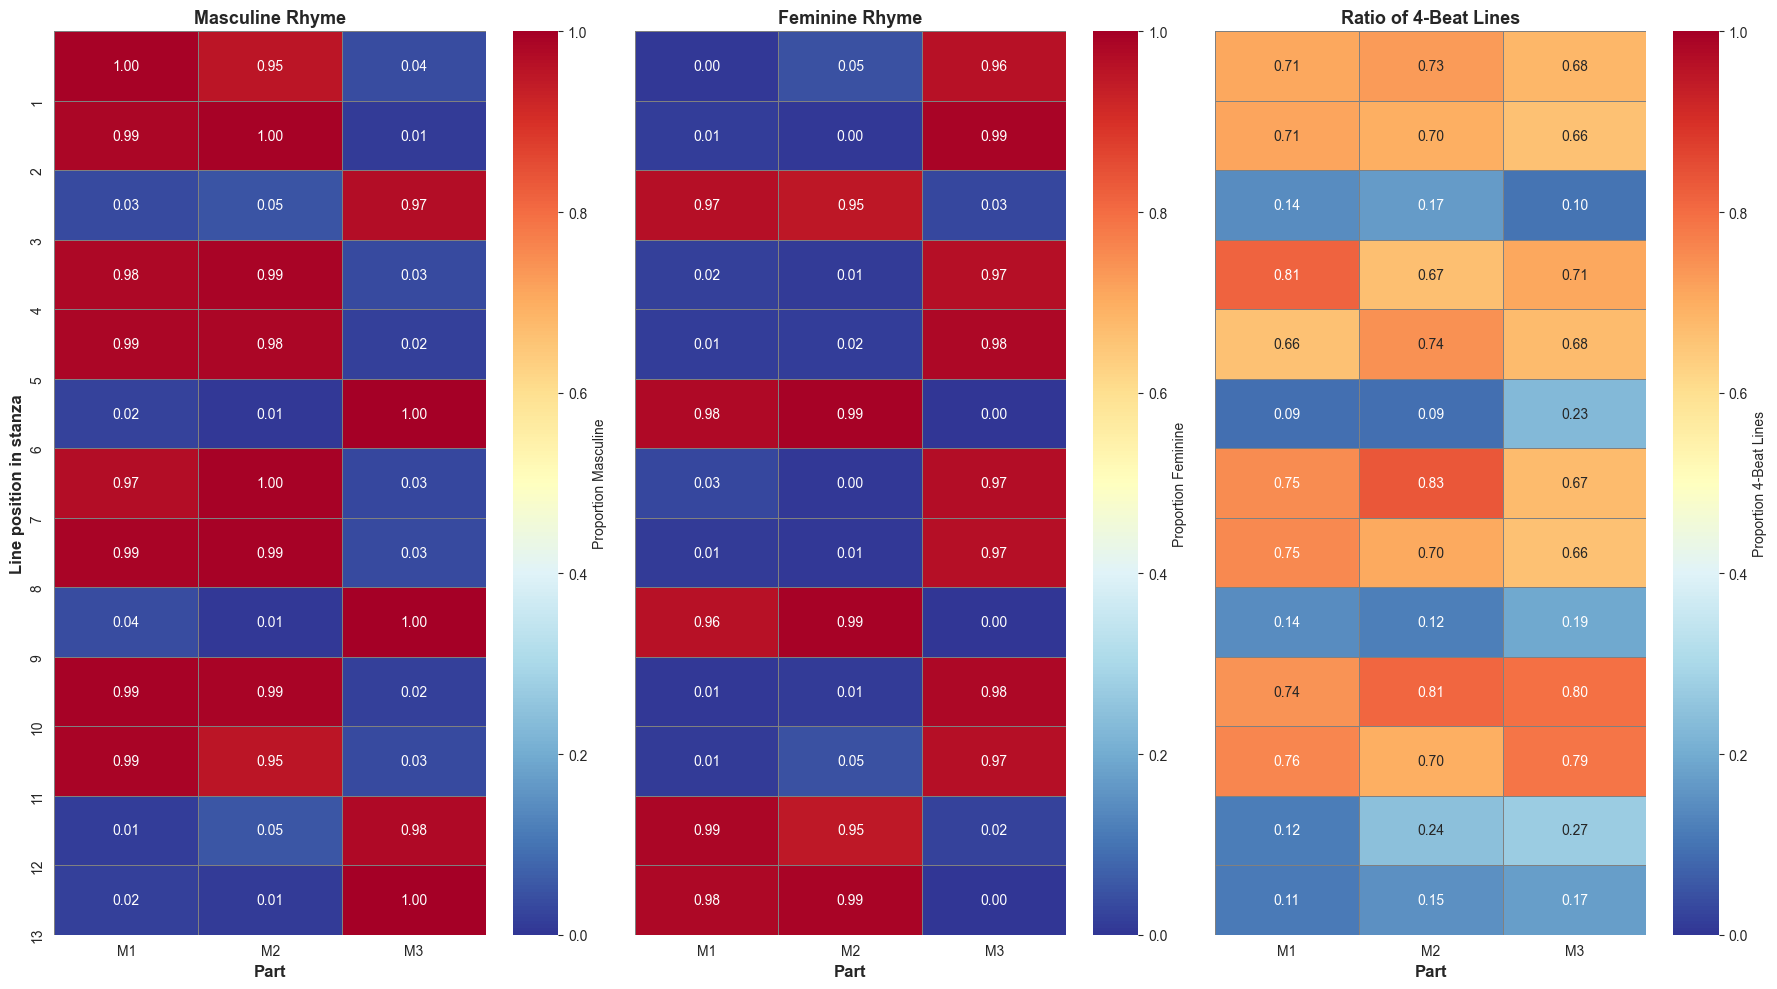

In [11]:
# heatmaps
print("\n" + "=" * 80)
print("HEATMAPS: Metrical Patterns by Position and Part")
print("=" * 80)

# 1. Masculine cadence
heatmap_data_masc = []
for part in ['M1', 'M2', 'M3']:
    part_data = rq1_df[rq1_df['part'] == part]
    row = {}
    for pos in range(1, 14):
        pos_data = part_data[part_data['stanza_line'] == pos]
        if len(pos_data) > 0:
            masc_prop = (pos_data['cadence'] == 'masculine').mean()
            row[pos] = masc_prop
        else:
            row[pos] = np.nan
    heatmap_data_masc.append(row)

heatmap_df_masc = pd.DataFrame(heatmap_data_masc, index=['M1', 'M2', 'M3']).T
heatmap_df_masc.index.name = 'Position'

# 2. Feminine cadence
heatmap_data_fem = []
for part in ['M1', 'M2', 'M3']:
    part_data = rq1_df[rq1_df['part'] == part]
    row = {}
    for pos in range(1, 14):
        pos_data = part_data[part_data['stanza_line'] == pos]
        if len(pos_data) > 0:
            fem_prop = (pos_data['cadence'] == 'feminine').mean()
            row[pos] = fem_prop
        else:
            row[pos] = np.nan
    heatmap_data_fem.append(row)

heatmap_df_fem = pd.DataFrame(heatmap_data_fem, index=['M1', 'M2', 'M3']).T
heatmap_df_fem.index.name = 'Position'

# 3. Proportion of 4-beat lines
heatmap_data_4beat_prop = []
for part in ['M1', 'M2', 'M3']:
    part_data = rq1_df[rq1_df['part'] == part]
    row = {}
    for pos in range(1, 14):
        pos_data = part_data[part_data['stanza_line'] == pos]
        if len(pos_data) > 0:
            prop_4beat = (pos_data['beats'] == 4).mean()
            row[pos] = prop_4beat
        else:
            row[pos] = np.nan
    heatmap_data_4beat_prop.append(row)

heatmap_df_4beat_prop = pd.DataFrame(heatmap_data_4beat_prop, index=['M1', 'M2', 'M3']).T
heatmap_df_4beat_prop.index.name = 'Position'

# Create all three heatmaps side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# 1. Masculine cadence heatmap
ax1 = axes[0]
sns.heatmap(heatmap_df_masc, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            vmin=0, vmax=1, center=0.5, cbar_kws={'label': 'Proportion Masculine'},
            linewidths=0.5, linecolor='gray', ax=ax1, cbar=True)
ax1.set_xlabel('Part', fontsize=12, fontweight='bold')
ax1.set_ylabel('Line position in stanza', fontsize=12, fontweight='bold')
ax1.set_title('Masculine Rhyme', fontsize=13, fontweight='bold')
ax1.set_yticks(range(1, 14))
ax1.set_yticklabels(range(1, 14))

# 2. Feminine cadence heatmap
ax2 = axes[1]
sns.heatmap(heatmap_df_fem, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            vmin=0, vmax=1, center=0.5, cbar_kws={'label': 'Proportion Feminine'},
            linewidths=0.5, linecolor='gray', ax=ax2, cbar=True)
ax2.set_xlabel('Part', fontsize=12, fontweight='bold')
ax2.set_ylabel('', fontsize=12)
ax2.set_title('Feminine Rhyme', fontsize=13, fontweight='bold')
ax2.set_yticks(range(1, 14))
ax2.set_yticklabels([])

# 3. Proportion of 4-beat lines heatmap
ax3 = axes[2]
sns.heatmap(heatmap_df_4beat_prop, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            vmin=0, vmax=1, center=0.5, cbar_kws={'label': 'Proportion 4-Beat Lines'},
            linewidths=0.5, linecolor='gray', ax=ax3, cbar=True)
ax3.set_xlabel('Part', fontsize=12, fontweight='bold')
ax3.set_ylabel('', fontsize=12)
ax3.set_title('Ratio of 4-Beat Lines', fontsize=13, fontweight='bold')
ax3.set_yticks(range(1, 14))
ax3.set_yticklabels([])

plt.tight_layout()
plt.show()

## Adherence by Part and Position


RULE ADHERENCE BY MANUSCRIPT: Beat Constraint vs Rhyme Type Constraint

Manuscripts sorted by beat constraint adherence:
manuscript  adherence_rate_beat  adherence_rate_rhyme  n_lines_beat
         K             0.861538              1.000000            65
         O             0.803249              0.991576          1662
         G             0.791175              0.986327          1609
         C             0.789671              0.983533          1336
         A             0.788317              0.984296          1592
         B             0.788192              0.979306          1643
         D             0.784848              0.987273          1650
         E             0.775934              0.991701           241
         F             0.767652              0.988533          1657
         Z             0.765073              0.975052           481
        Br             0.752809              0.979401           534
         W             0.737418              0.986871         

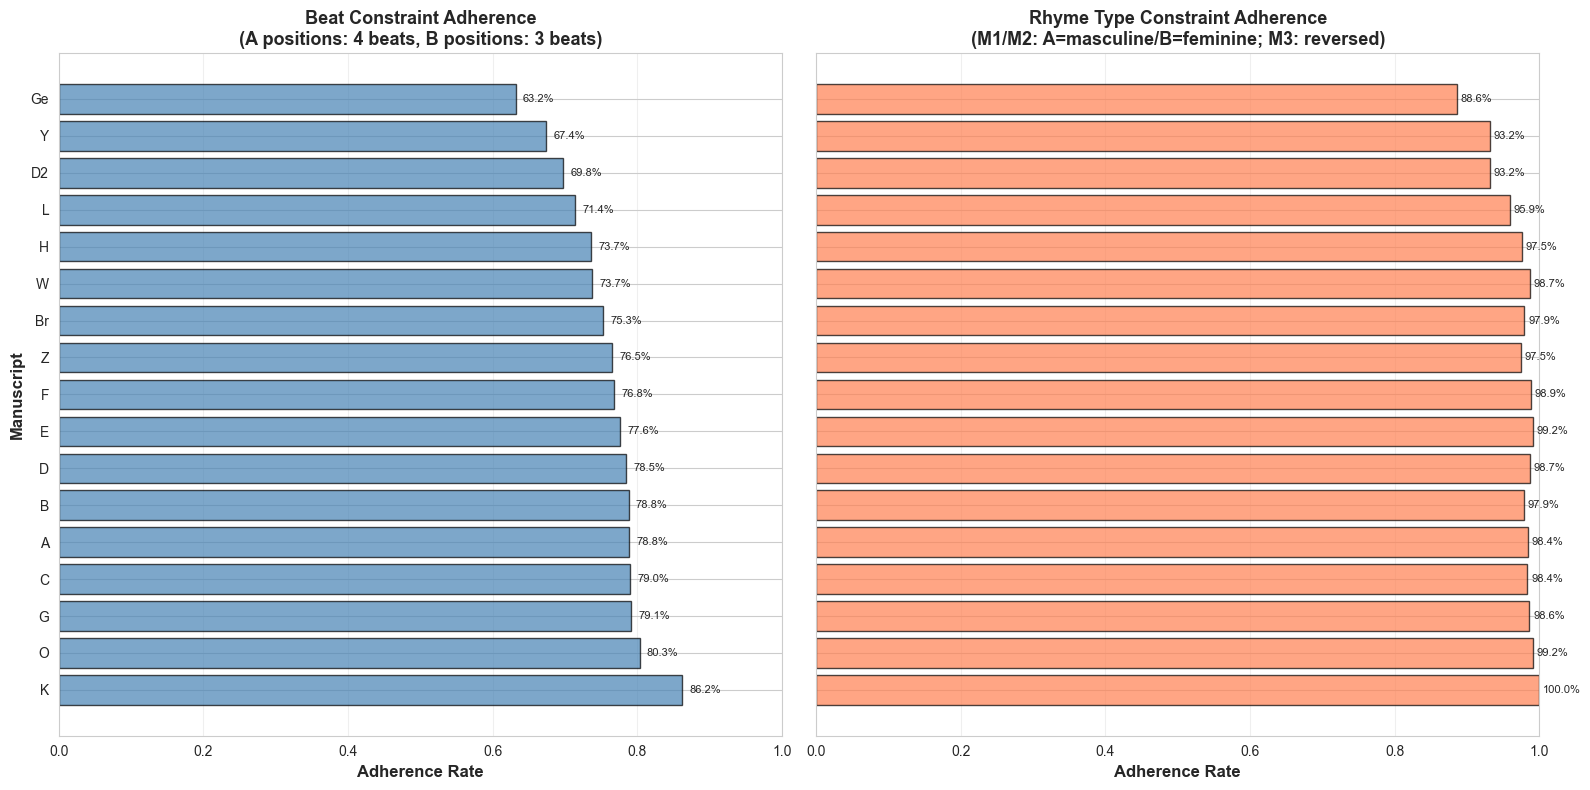

In [12]:
# Step 4: Test rule adherence by manuscript (fine-grained: beat vs rhyme type constraints)
print("\n" + "=" * 80)
print("RULE ADHERENCE BY MANUSCRIPT: Beat Constraint vs Rhyme Type Constraint")
print("=" * 80)

# Calculate adherence for each constraint separately
ms_beat_adherence = rq1_df.groupby('ms')['matches_beat_constraint'].agg(['mean', 'count']).reset_index()
ms_beat_adherence.columns = ['manuscript', 'adherence_rate', 'n_lines']

ms_rhyme_adherence = rq1_df.groupby('ms')['matches_rhyme_type_constraint'].agg(['mean', 'count']).reset_index()
ms_rhyme_adherence.columns = ['manuscript', 'adherence_rate', 'n_lines']

# Merge to ensure consistent ordering
ms_comparison = ms_beat_adherence.merge(ms_rhyme_adherence, on='manuscript', suffixes=('_beat', '_rhyme'))
ms_comparison = ms_comparison.sort_values('adherence_rate_beat', ascending=False)

print("\nManuscripts sorted by beat constraint adherence:")
print(ms_comparison[['manuscript', 'adherence_rate_beat', 'adherence_rate_rhyme', 'n_lines_beat']].to_string(index=False))

# Create two side-by-side horizontal bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Left plot: Beat constraint adherence
y_pos = range(len(ms_comparison))
bars1 = ax1.barh(y_pos, ms_comparison['adherence_rate_beat'], 
                 color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(ms_comparison['manuscript'])
ax1.set_xlabel('Adherence Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('Manuscript', fontsize=12, fontweight='bold')
ax1.set_title('Beat Constraint Adherence\n(A positions: 4 beats, B positions: 3 beats)', 
              fontsize=13, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)

# Add value labels for beat constraint
for i, (bar, rate) in enumerate(zip(bars1, ms_comparison['adherence_rate_beat'])):
    ax1.text(rate + 0.01, i, f'{rate:.1%}', va='center', fontsize=8)

# Right plot: Rhyme type constraint adherence
bars2 = ax2.barh(y_pos, ms_comparison['adherence_rate_rhyme'], 
                 color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Adherence Rate', fontsize=12, fontweight='bold')
ax2.set_title('Rhyme Type Constraint Adherence\n(M1/M2: A=masculine/B=feminine; M3: reversed)', 
              fontsize=13, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)

# Add value labels for rhyme type constraint
for i, (bar, rate) in enumerate(zip(bars2, ms_comparison['adherence_rate_rhyme'])):
    ax2.text(rate + 0.005, i, f'{rate:.1%}', va='center', fontsize=8)

plt.tight_layout()
plt.show()


## RQ2: Rhythmical clustering

Do manuscripts cluster by their rhythmic patterns? If so, what features drive the clustering?

### 1. Choose encoding

To start with this question, we will use one of the earlier obtained encodings:

**Prosodic encoding** (`'prosodic'`): Binary stress pattern as `w`/`S` string
- Example: `[0,1,0,0,1,0,1,0,1]` → `"wSwwSwSwS"`
**Interstress interval encoding** (`'interval'`): Gap sizes between stressed syllables
- Example: `[0,1,0,0,1,0,1,0,1]` → `[1, 2, 1, 1]` (anacrusis, gaps, clausula)
**Ictus position encoding** (`'ictus'`): Intervals indexed by normalized beat position
- Example: `[1, 2, 1, 1]` → `[(0.0,1), (0.33,2), (0.67,1), (1.0,1)]` (relative positions)
**Prosodic with boundaries** (`'prosodic_marked'`): Line- and word-aware prosody with markers
- Symbols: `#` (start), `w`/`S` per syllable, `.` (word boundary), `|` (end)
- Example: `#wS.w.|`

### 2. Extract n-grams

Next, from each encoding, we extract consecutive subsequences (n-grams) using a **sliding window** (overlapping extraction). We set `NGRAM_MIN` and `NGRAM_MAX` to the n-gram size range (e.g., 2-3 = bigrams + trigrams).

**Example with 2-3 grams (overlapping):**

- **Prosodic encoding:** `"wSwwSwSwS"` (9 symbols)
  - 2-grams (sliding window): `wS, Sw, ww, wS, Sw, wS, Sw, wS` (8 bigrams)
  - 3-grams (sliding window): `wSw, Sww, wwS, wSw, SwS, wSw, SwS` (7 trigrams)
  - **Total:** 15 n-grams from this 9-symbol line

- **Interstress encoding:** `[1, 2, 1, 1]` (4 values)
  - 2-grams (sliding window): `(1,2), (2,1), (1,1)` (3 bigrams)
  - 3-grams (sliding window): `(1,2,1), (2,1,1)` (2 trigrams)
  - **Total:** 5 n-grams from this 4-value sequence

- **Ictus-position encoding:** `[(0.0,1), (0.33,2), (0.67,1), (1.0,1)]` (4 tuples)
  - 2-grams: `((0.0,1),(0.33,2)), ((0.33,2),(0.67,1)), ((0.67,1),(1.0,1))` (3 bigrams)
  - 3-grams: `((0.0,1),(0.33,2),(0.67,1)), ((0.33,2),(0.67,1),(1.0,1))` (2 trigrams)
  - **Total:** 5 n-grams from this 4-tuple sequence

### 3. Chunk (optional)

Optionally, we can perform chunking when setting `CHUNK_SIZE`
- `None`: Use all verse lines per manuscript 
- `200`: Split manuscripts into 200-line chunks 

When chunking is enabled, we can also set the `CHUNK_METHOD` to either `sequential` (non-overlapping consecutive blocks) or `random` (random samples of verse lines pulled)

### 4. Include tail or not?

We can also include or exclude the clausula of verse lines, by setting `INCLUDE_TAIL` to `False`. Why? We saw earlier that the verse-ending (i.e. tail) might make all manuscripts look identical, since there is a lot of masculine rhyme-endings.

### 5. Set `df`

Based on all of the params above, we then build our feature matrix, where rows are manuscript chunks, and columns are the n-grams. Optionally, we can set `DF_MIN` (only keep n-grams appearing in ≥ `DF_MIN` samples) and `DF_MAX` (exclude n-grams in > `DF_MAX` samples).

### 6. Normalize

Next, we normalize the counts. The raw n-gram counts are dominated by high-frequency patterns (e.g., `"wS"` appears everywhere). We normalize to highlight distinctive patterns. Some normalization techniques to play with:

- **TF-IDF** (`'tfidf'`): Term Frequency × Inverse Document Frequency
    - Downweights common n-grams (like `wS`)
    - Upweights rare n-grams (like `www`)
    - Standard in stylometry for exactly this reason
    - **Example:** `"wS"` count=1000 → TF-IDF=0.2, `"SSS"` count=10 → TF-IDF=0.8

- **L1 normalization** (`'l1'`): Proportions (each row sums to 1)
    - Treats n-gram profile as probability distribution
    - Use with Jensen-Shannon distance

- **$Z$-score** (`'zscore'`): Standardize (mean=0, std=1 per feature)
    - Use with Euclidean distance
    - Compares absolute magnitudes

### 7. Calculate distances

We calculate the disntances, choose distance metric wisely:

- **Cosine distance** (`'cosine'`): angle between n-gram vectors; best with TF-IDF

- **Euclidean distance** (`'euclidean'`): straight-line distance; best with $z$-scores

- **Jensen-Shannon divergence** (`'jsd'`): probability distribution distance; best with L1 norm

### 8. Cluster

Finally, we cluster, and build a tree showing manuscript relationships



### Single source of truth
All params are set here!

Good starting point:

```
ENCODING: prosodic_marked
CHUNK_SIZE = 250
CHUNK_METHOD = 'random'
N_CHUNKS_PER_MS = 4
INCLUDE_TAIL = False
NGRAM_MIN = 3
NGRAM_MAX = 3
FEATURE_SELECTION = 'both'
TOP_N_FEATURES = 50 
DF_MIN = 2
DF_MAX = None
NORMALIZE = 'tfidf'
DISTANCE_METRIC: 'cosine'
```

In [13]:
# 1. Encoding Type
# -----------------
# Which metrical representation to extract for n-gram analysis
#   'prosodic': Stress patterns as w/S strings (e.g., "wSwS")
#   'prosodic_marked': Stress with boundaries (# start, . word, | end), e.g., "#wS.w.|"
#   'interval': Gap sizes between stresses (e.g., [1, 2, 1])
#   'ictus': Positional intervals (e.g., [(0.0,1), (0.5,2)])
ENCODING = 'prosodic_marked'

# 2. Chunking Strategy
# --------------------
# Whether and how to split manuscripts into samples
#   CHUNK_SIZE: None (use all data) or integer (lines per chunk, e.g., 100)
#   CHUNK_METHOD: 'sequential' (consecutive lines) or 'random' (shuffled lines)
#   N_CHUNKS_PER_MS: Max chunks per manuscript (None = exhaust all data, e.g., 5 = cap at 5)
#
# IMPORTANT: Chunks are ALWAYS non-overlapping!
#   - Sequential: chunks are consecutive blocks (lines 0-99, 100-199, ...)
#   - Random: shuffle once, then take consecutive blocks from shuffled indices
#   - Each MS generates as many chunks as possible until exhausted
#   - N_CHUNKS_PER_MS caps the maximum (if set)
#   - MSS with fewer than CHUNK_SIZE lines are excluded
#
# Example: CHUNK_SIZE=94, N_CHUNKS_PER_MS=None (exhaust all data)
#   - MS with 1821 lines → 19 chunks (1786 lines used, 35 unused)
#   - MS with 350 lines → 3 chunks (282 lines used, 68 unused)
#   - MS with 67 lines → 0 chunks (excluded)
#
# Example: CHUNK_SIZE=100, N_CHUNKS_PER_MS=5 (cap at 5 chunks)
#   - MS with 1821 lines → 5 chunks (500 lines used, 1321 unused)
#   - MS with 350 lines → 3 chunks (300 lines used, 50 unused)
#   - MS with 67 lines → 0 chunks (excluded)
#
# Note: TF-IDF normalization helps account for different sample sizes
CHUNK_SIZE = 200
CHUNK_METHOD = 'random' # disrupt order of lines when random
N_CHUNKS_PER_MS = 5

# 3. Tail Handling
# ----------------
# Whether to include the final element (clausula for intervals, final symbol for prosodic)
#   False: Exclude cadence (recommended if RQ1 shows high adherence)
#   True: Include cadence
# WH: should be False -- we sawe earlier here almost every line predictably ends with either 'S' (masculine) or 'w' (feminine), and this varies by:
# Part (M1/M2: A=masculine, M3: reversed)
# Position (A-positions vs B-positions)
# so including the tail COULD drive clustering by PART (M1/M2 vs M3) rather than by manuscript!!
INCLUDE_TAIL = False

# 4. N-gram Size Range
# --------------------
# Range of n-gram lengths to extract (e.g., 2-3 = bigrams and trigrams)
NGRAM_MIN = 3
NGRAM_MAX = 3

# 5. Feature Selection Method
# ----------------------------
# How to select which n-grams to use as features:
#   'df': Document frequency filtering
#         - Filter by DF_MIN (minimum samples containing n-gram)
#         - Filter by DF_MAX (maximum samples, or None to disable)
#         - Sample-driven: selection based on presence across samples!!
#   'top_n': Top N most frequent features from FULL corpus
#            - Extract ALL n-grams from FULL corpus (all verses, all manuscripts)
#            - Select top TOP_N_FEATURES by global frequency
#            - Corpus-driven: selection based on total count across entire corpus
#   'both': Apply DF filter first, then select top N from remaining
#           - Combines both methods: DF filter removes noise, then top-N selects most frequent
FEATURE_SELECTION = 'both'  # 'df', 'top_n', or 'both'
TOP_N_FEATURES = 50       # Only used if FEATURE_SELECTION in ['top_n', 'both']

# 5a. Document Frequency Filtering (only used if FEATURE_SELECTION in ['df', 'both'])
# -----------------------------------------------------------------------------------
# Keep only n-grams appearing in DF_MIN to DF_MAX manuscripts
#   DF_MIN: Minimum number of MSS (removes hapax legomena)
#   DF_MAX: Maximum number of MSS or None (removes ubiquitous patterns)
DF_MIN = 2
DF_MAX = None

# 6. Feature Normalization
# ------------------------
# How to weight n-gram counts before computing distances
#   'tfidf': Downweight common, upweight distinctive (recommended)
#   'l1': Proportions (for probability-based distances)
#   'zscore': Standardize (for magnitude-based distances)
NORMALIZE = 'tfidf'

# 7. Distance Metric
# ------------------
# How to compare n-gram feature vectors
#   'cosine': Angle between vectors (recommended with TF-IDF)
#   'euclidean': Straight-line distance (use with z-scores)
#   'jsd': Jensen-Shannon divergence (use with L1)
DISTANCE_METRIC = 'cosine'

# 8. Beat Count Stratification
# ----------------------------
# CRITICAL: Ictus encoding confounds beat count with interval pattern!
# Normalized positions (0.0, 0.33, 0.67, 1.0) can ONLY come from 3-beat lines.
# Normalized positions (0.0, 0.25, 0.5, 0.75, 1.0) can ONLY come from 4-beat lines.
# This means ictus implicitly encodes beat count, not just interval patterns.
#
# Solution: Stratify by beat count before clustering to remove confound.
#   None: Use all beat counts (DEFAULT - confounded for ictus!)
#   2, 3, 4: Use only lines with this beat count
#   'separate': Build separate trees for each beat count and compare
BEAT_COUNT_FILTER = 'separate'

# 9. Manuscript Filtering
# -----------------------
# Exclude manuscripts with fewer than MIN_LINES verse lines
MIN_LINES = 100

# 10. Reproducibility
# -------------------
# Random seed for chunking (if CHUNK_METHOD='random')
RNG_SEED = 42

# print configuration
print(f"Configuration: {ENCODING} encoding, {NGRAM_MIN}-{NGRAM_MAX} grams, "
      f"{NORMALIZE}+{DISTANCE_METRIC}, tail={'included' if INCLUDE_TAIL else 'excluded'}")
print(f"Feature selection: {FEATURE_SELECTION}" + 
      (f" (TOP_N={TOP_N_FEATURES})" if FEATURE_SELECTION in ['top_n', 'both'] else 
       f" (DF_MIN={DF_MIN}, DF_MAX={DF_MAX})"))
if BEAT_COUNT_FILTER is not None and BEAT_COUNT_FILTER != 'separate':
    print(f"Beat count filter: {BEAT_COUNT_FILTER}-beat lines only")
elif BEAT_COUNT_FILTER == 'separate':
    print(f"Beat count stratification: separate trees for each beat count")
if CHUNK_SIZE:
    print(f"Chunking: {CHUNK_METHOD} method, {CHUNK_SIZE} lines per chunk" + 
          (f", {N_CHUNKS_PER_MS} samples/MS" if CHUNK_METHOD == 'random' else ""))


Configuration: prosodic_marked encoding, 3-3 grams, tfidf+cosine, tail=excluded
Feature selection: both (TOP_N=50)
Beat count stratification: separate trees for each beat count
Chunking: random method, 200 lines per chunk, 5 samples/MS


### Step 1 and 2: Extract Encodings and Generate N-grams

For each manuscript (or chunk), we:
1. Extract the appropriate encoding (prosodic/interval/ictus)
2. Remove tail if `INCLUDE_TAIL=False`
3. Generate **overlapping** n-grams using a sliding window
4. Count n-gram frequencies

**N-gram extraction:** We use overlapping n-grams (standard sliding-window approach). For example, with `NGRAM_MIN=2, NGRAM_MAX=3`:
- Line: `"wSwwS"` (5 symbols)
- 2-grams: `["wS", "Sw", "ww", "wS"]` (4 bigrams, extracted at positions 0,1,2,3)
- 3-grams: `["wSw", "Sww", "wwS"]` (3 trigrams, extracted at positions 0,1,2)
- **Total:** 7 n-grams from one 5-symbol line


In [14]:
import numpy as np
from collections import Counter

np.random.seed(RNG_SEED)

# Helper functions
def extract_encoding(row, encoding_type, include_tail):
    """Extract the appropriate encoding from a row, with optional tail removal."""
    if encoding_type == 'prosodic':
        s = row['prosody']
        if not include_tail and len(s) > 0:
            s = s[:-1]  # remove final symbol
        return s
    
    elif encoding_type == 'prosodic_marked':
        s = row.get('prosody_marked')
        if s is None:
            return None
        if not include_tail and isinstance(s, str) and '|' in s:
            # remove the last syllable symbol (w/S) before the end marker '|'
            chars = list(s)
            end_idx = len(chars) - 1
            last_sym = -1
            for i in range(end_idx - 1, -1, -1):
                if chars[i] in ('w', 'S'):
                    last_sym = i
                    break
            if last_sym != -1:
                del chars[last_sym]
            s = ''.join(chars)
        return s
    
    elif encoding_type == 'interval':
        intervals = row['intervals']
        if not include_tail and len(intervals) > 0:
            intervals = intervals[:-1]  # remove clausula (last interval)
        return intervals
    
    elif encoding_type == 'ictus':
        # normalize ictus positions by beat count for cross-line comparability
        ictus_vec = row['ictus_vector']
        n_beats = row['beats']
        
        if n_beats <= 1 or len(ictus_vec) == 0:
            return []
        
        # remove tail (clausula) if requested
        # clausula is the last element in ictus_vector (highest ictus_idx)
        if not include_tail:
            max_idx = max(v[0] for v in ictus_vec)
            ictus_vec = [v for v in ictus_vec if v[0] < max_idx]
        
        if len(ictus_vec) == 0:
            return []
        
        # normalize positions: (relative_position, interval_value)
        # relative_position = ictus_idx / max_ictus_idx, rounded to 2 decimals
        # this makes positions comparable across different beat counts
        # WH: tried to do this with relative positions, but then: this will implicitly encoding beat count
        # e.g. ((0.33, 1), (0.67, 1)) can ONLY come from 3-beat lines;  ((0.25, 1), (0.5, 1)) can ONLY come from 4-beat lines
        max_idx = max(v[0] for v in ictus_vec)
        normalized = []
        for idx, val in ictus_vec:
            rel_pos = round(idx / max_idx, 2) if max_idx > 0 else 0.0
            normalized.append((rel_pos, val))
        
        return normalized
    
    return None


def generate_ngrams(encoding, ngram_min, ngram_max, encoding_type):
    """Generate n-grams from an encoding."""
    ngrams = []
    
    if encoding is None or len(encoding) == 0:
        return ngrams
    
    if encoding_type in ('prosodic', 'prosodic_marked'):
        # String n-grams: slide over characters (including boundary markers for prosodic_marked)
        for n in range(ngram_min, ngram_max + 1):
            for i in range(len(encoding) - n + 1):
                ngrams.append(encoding[i:i+n])
    
    elif encoding_type == 'interval':
        # Tuple n-grams: [1, 2, 1] → [(1,2), (2,1)]
        for n in range(ngram_min, ngram_max + 1):
            for i in range(len(encoding) - n + 1):
                ngrams.append(tuple(encoding[i:i+n]))
    
    elif encoding_type == 'ictus':
        # Positional tuple n-grams: [(0.0,1), (0.5,2), (1.0,1)] → [((0.0,1),(0.5,2)), ((0.5,2),(1.0,1))]
        for n in range(ngram_min, ngram_max + 1):
            for i in range(len(encoding) - n + 1):
                ngrams.append(tuple(encoding[i:i+n]))
    
    return ngrams


# filter manuscripts by coverage
ms_counts = encodings_df.groupby('ms').size()
viable_mss = ms_counts[ms_counts >= MIN_LINES].index.tolist()

print(f"\nManuscripts with >= {MIN_LINES} lines: {len(viable_mss)}")
print(f"  Included: {', '.join(sorted(viable_mss))}")
excluded = [ms for ms in ms_counts.index if ms not in viable_mss]
if excluded:
    print(f"  Excluded: {', '.join(sorted(excluded))}")

# CORPUS-LEVEL FEATURE SELECTION (if top_n or both)
# Extract ALL n-grams from FULL corpus before chunking
corpus_ngrams = None
top_n_list = None

if FEATURE_SELECTION in ['top_n', 'both']:
    print(f"\n{'='*80}")
    print(f"CORPUS-LEVEL FEATURE EXTRACTION (FEATURE_SELECTION='{FEATURE_SELECTION}')")
    print(f"{'='*80}")
    
    # Apply beat count filter to corpus data if specified
    corpus_df = encodings_df.copy()
    if BEAT_COUNT_FILTER is not None and BEAT_COUNT_FILTER != 'separate':
        corpus_df = corpus_df[corpus_df['beats'] == BEAT_COUNT_FILTER]
        print(f"Filtered corpus to {BEAT_COUNT_FILTER}-beat lines: {len(corpus_df)} lines")
    
    # Extract ALL n-grams from FULL corpus
    corpus_ngrams = Counter()
    total_verses = 0
    for _, row in corpus_df.iterrows():
        encoding = extract_encoding(row, ENCODING, INCLUDE_TAIL)
        ngrams = generate_ngrams(encoding, NGRAM_MIN, NGRAM_MAX, ENCODING)
        corpus_ngrams.update(ngrams)
        total_verses += 1
    
    print(f"Extracted n-grams from {total_verses:,} verse lines")
    print(f"Total unique n-grams in corpus: {len(corpus_ngrams):,}")
    print(f"Total n-gram occurrences: {sum(corpus_ngrams.values()):,}")
    
    # Show top 10 most frequent
    print(f"\nTop 10 most frequent n-grams in corpus:")
    for ngram, count in corpus_ngrams.most_common(10):
        print(f"  {str(ngram)[:50]:50s}  count={count:,}")
    
    # Store top N list for later use
    top_n_list = [ngram for ngram, count in corpus_ngrams.most_common(TOP_N_FEATURES)]
    print(f"\nSelected top {TOP_N_FEATURES} features from corpus")
    print(f"  Most frequent: {str(top_n_list[0])[:50]} (count={corpus_ngrams[top_n_list[0]]:,})")
    print(f"  Least frequent (in top N): {str(top_n_list[-1])[:50]} (count={corpus_ngrams[top_n_list[-1]]:,})")
    print(f"{'='*80}\n")

# extract n-grams per manuscript (or chunk)
samples = []  # Each entry: {'ms': 'A', 'chunk_id': 0, 'ngrams': Counter(...)}

for ms in sorted(viable_mss):
    ms_data = encodings_df[encodings_df['ms'] == ms].copy()
    
    # apply beat count filter if specified
    if BEAT_COUNT_FILTER is not None and BEAT_COUNT_FILTER != 'separate':
        ms_data = ms_data[ms_data['beats'] == BEAT_COUNT_FILTER]
    
    ms_data = ms_data.sort_values('cumulative_line').reset_index(drop=True)
    
    n_lines = len(ms_data)
    
    # Skip manuscript if no data after beat count filtering
    if n_lines == 0:
        if BEAT_COUNT_FILTER is not None and BEAT_COUNT_FILTER != 'separate':
            print(f"  {ms:4s}: SKIPPED (no lines with {BEAT_COUNT_FILTER} beats after filtering)")
        continue
    
    # chunking logic
    if CHUNK_SIZE is None:
        # Use all data as one chunk
        chunks = [(0, ms_data)]
    elif CHUNK_METHOD == 'sequential':
        # Non-overlapping sequential chunks
        chunks = []
        
        # Calculate how many chunks we can create (exhaust all data)
        max_chunks_possible = n_lines // CHUNK_SIZE
        
        if max_chunks_possible == 0:
            print(f"  {ms:4s}: SKIPPED ({n_lines:4d} lines < {CHUNK_SIZE} CHUNK_SIZE)")
            continue
        
        # Apply N_CHUNKS_PER_MS limit if set, otherwise use all possible chunks
        if N_CHUNKS_PER_MS is not None:
            n_chunks_actual = min(N_CHUNKS_PER_MS, max_chunks_possible)
        else:
            n_chunks_actual = max_chunks_possible
        
        # Create chunks
        for i in range(n_chunks_actual):
            start_idx = i * CHUNK_SIZE
            end_idx = start_idx + CHUNK_SIZE
            chunk_data = ms_data.iloc[start_idx:end_idx]
            chunks.append((i, chunk_data))
        
        # Report
        lines_used = n_chunks_actual * CHUNK_SIZE
        lines_unused = n_lines - lines_used
        if N_CHUNKS_PER_MS is not None and n_chunks_actual < N_CHUNKS_PER_MS:
            print(f"  {ms:4s}: {n_chunks_actual}/{N_CHUNKS_PER_MS} chunks | {lines_used:4d}/{n_lines:4d} lines | {lines_unused:4d} unused")
        elif lines_unused > 0:
            print(f"  {ms:4s}: {n_chunks_actual} chunks   | {lines_used:4d}/{n_lines:4d} lines | {lines_unused:4d} unused")
            
    elif CHUNK_METHOD == 'random':
        # Non-overlapping random chunks
        chunks = []
        
        # Calculate how many chunks we can create (exhaust all data)
        max_chunks_possible = n_lines // CHUNK_SIZE
        
        if max_chunks_possible == 0:
            print(f"  {ms:4s}: SKIPPED ({n_lines:4d} lines < {CHUNK_SIZE} CHUNK_SIZE)")
            continue
        
        # Apply N_CHUNKS_PER_MS limit if set, otherwise use all possible chunks
        if N_CHUNKS_PER_MS is not None:
            n_chunks_actual = min(N_CHUNKS_PER_MS, max_chunks_possible)
        else:
            n_chunks_actual = max_chunks_possible
        
        # Shuffle all indices ONCE to ensure non-overlapping chunks
        all_indices = np.arange(n_lines)
        np.random.shuffle(all_indices)
        
        # Take first n_chunks_actual * CHUNK_SIZE indices and split into chunks
        for i in range(n_chunks_actual):
            start_idx = i * CHUNK_SIZE
            end_idx = start_idx + CHUNK_SIZE
            chunk_indices = all_indices[start_idx:end_idx]
            chunk_data = ms_data.iloc[chunk_indices]
            chunks.append((i, chunk_data))
        
        # Report
        lines_used = n_chunks_actual * CHUNK_SIZE
        lines_unused = n_lines - lines_used
        if N_CHUNKS_PER_MS is not None and n_chunks_actual < N_CHUNKS_PER_MS:
            print(f"  {ms:4s}: {n_chunks_actual}/{N_CHUNKS_PER_MS} chunks | {lines_used:4d}/{n_lines:4d} lines | {lines_unused:4d} unused (random)")
        elif lines_unused > 0:
            print(f"  {ms:4s}: {n_chunks_actual} chunks   | {lines_used:4d}/{n_lines:4d} lines | {lines_unused:4d} unused (random)")
            
    else:
        raise ValueError(f"Unknown CHUNK_METHOD: {CHUNK_METHOD}")
    
    # extract n-grams from each chunk
    for chunk_id, chunk_data in chunks:
        all_ngrams = []
        
        for _, row in chunk_data.iterrows():
            encoding = extract_encoding(row, ENCODING, INCLUDE_TAIL)
            ngrams = generate_ngrams(encoding, NGRAM_MIN, NGRAM_MAX, ENCODING)
            all_ngrams.extend(ngrams)
        
        samples.append({
            'ms': ms,
            'chunk_id': chunk_id,
            'n_lines': len(chunk_data),
            'ngrams': Counter(all_ngrams)
        })

print(f"extracted n-grams: {len(samples)} samples from {len(viable_mss)} manuscripts")
if CHUNK_SIZE is not None:
    samples_per_ms = len(samples) / len(viable_mss)
    print(f"average samples per manuscript: {samples_per_ms:.1f}")

# df for all samples
samples_df = pd.DataFrame([
    {
        'manuscript': s['ms'],
        'chunk': s['chunk_id'],
        'n_lines': s['n_lines'],
        'unique_ngrams': len(s['ngrams']),
        'total_ngrams': sum(s['ngrams'].values())
    }
    for s in samples
])

print(f"\nShowing first 5 samples:")
display(samples_df.head(20))

print(f"\nSummary statistics (all {len(samples)} samples):")
display(samples_df.describe().round(1))



Manuscripts with >= 100 lines: 16
  Included: A, B, Br, C, D, D2, E, F, G, Ge, H, L, O, W, Y, Z
  Excluded: Ant, K

CORPUS-LEVEL FEATURE EXTRACTION (FEATURE_SELECTION='both')
Extracted n-grams from 16,354 verse lines
Total unique n-grams in corpus: 38
Total n-gram occurrences: 174,900

Top 10 most frequent n-grams in corpus:
  w.S                                                 count=32,110
  Sw.                                                 count=22,002
  .w.                                                 count=18,493
  .Sw                                                 count=17,906
  S.w                                                 count=13,457
  w.w                                                 count=12,444
  .S.                                                 count=10,713
  #w.                                                 count=8,532
  w.|                                                 count=5,832
  .wS                                                 count=4,671

Sele

,manuscript,chunk,n_lines,unique_ngrams,total_ngrams
0,A,0,200,32,2184
1,A,1,200,32,2172
2,A,2,200,32,2178
3,A,3,200,32,2261
4,A,4,200,30,2134
5,B,0,200,31,2171
6,B,1,200,31,2196
7,B,2,200,32,2263
8,B,3,200,30,2187
9,B,4,200,33,2147



Summary statistics (all 51 samples):


,chunk,n_lines,unique_ngrams,total_ngrams
count,51.0,51.0,51.0,51.0
mean,1.6,200.0,31.1,2131.5
std,1.4,0.0,1.3,127.7
min,0.0,200.0,28.0,1748.0
25%,0.0,200.0,30.0,2106.5
50%,1.0,200.0,31.0,2167.0
75%,3.0,200.0,32.0,2207.5
max,4.0,200.0,34.0,2335.0


The following cells run the standard analysis pipeline on the extracted n-grams.

**Important Note on Beat Count Stratification:**
- If `BEAT_COUNT_FILTER=None`: This pipeline analyzes **all lines** (confounded for ictus!)
- If `BEAT_COUNT_FILTER=2/3/4`: This pipeline analyzes **only lines with that beat count** (confound removed)
- If `BEAT_COUNT_FILTER='separate'`: This pipeline still runs on **all lines**, but the proper stratified analysis happens at the end (which builds separate trees for each beat count)

**Recommendation:** When using ictus encoding with `BEAT_COUNT_FILTER='separate'`, focus on the Cell 39 output for the main results.


Before building the feature matrix, let's inspect the raw n-gram frequencies across manuscripts.


In [15]:
# n-grams per manuscript (sum across chunks if chunking is enabled)
ms_ngrams = {}
for sample in samples:
    ms = sample['ms']
    if ms not in ms_ngrams:
        ms_ngrams[ms] = Counter()
    ms_ngrams[ms].update(sample['ngrams'])

# summary dataframe
ms_summary = []
for ms in sorted(ms_ngrams.keys()):
    ngram_counter = ms_ngrams[ms]
    ms_summary.append({
        'manuscript': ms,
        'total_ngrams': sum(ngram_counter.values()),
        'unique_ngrams': len(ngram_counter),
        'top_ngram': ngram_counter.most_common(1)[0][0] if ngram_counter else None,
        'top_ngram_count': ngram_counter.most_common(1)[0][1] if ngram_counter else 0
    })

ms_summary_df = pd.DataFrame(ms_summary)
display(ms_summary_df)

# top 10 most common n-grams per manuscript
for i, ms in enumerate(sorted(ms_ngrams.keys())[:5]):
    print(f"\n{ms}:")
    top10 = ms_ngrams[ms].most_common(10)
    for ngram, count in top10:
        ngram_str = str(ngram)[:50]
        print(f"  {ngram_str:50s}  count={count:5d}")



,manuscript,total_ngrams,unique_ngrams,top_ngram,top_ngram_count
0,A,10929,35,w.S,1965
1,B,10964,35,w.S,2023
2,Br,6156,33,w.S,1120
3,C,10849,36,w.S,1958
4,D,10789,34,w.S,2002
5,D2,1941,31,w.S,344
6,E,2104,32,w.S,384
7,F,10742,35,w.S,1973
8,G,11150,36,w.S,2030
9,H,5328,35,w.S,952



A:
  w.S                                                 count= 1965
  Sw.                                                 count= 1429
  .Sw                                                 count= 1163
  .w.                                                 count= 1149
  w.w                                                 count=  854
  S.w                                                 count=  762
  .S.                                                 count=  579
  #w.                                                 count=  506
  w.|                                                 count=  368
  .wS                                                 count=  299

B:
  w.S                                                 count= 2023
  Sw.                                                 count= 1405
  .Sw                                                 count= 1181
  .w.                                                 count= 1173
  w.w                                                 count=  813
  

### Step 3: Build feature matrix with Feature Selection

We create a matrix where:
- rows = samples (manuscripts or chunks)
- columns = n-grams (selected by chosen method)

**Feature Selection Methods:**

1. **Document Frequency (`df`)**: Sample-driven selection
   - Only keep n-grams appearing in at least `DF_MIN` samples and at most `DF_MAX` samples
   - Removes noise (hapax legomena) and optionally removes ubiquitous patterns
   - Selection based on **presence across samples**

2. **Top-N Corpus Frequency (`top_n`)**: Corpus-driven selection
   - Extract ALL n-grams from FULL corpus (all verses, all manuscripts) before chunking
   - Count total frequency of each n-gram across entire corpus
   - Select top `TOP_N_FEATURES` most frequent n-grams
   - Selection based on **total count across entire corpus**

3. **Both (`both`)**: Combined approach
   - Apply DF filter first to remove noise
   - Then select top N from remaining features
   - Combines benefits of both methods


In [16]:
# FEATURE SELECTION LOGIC
n_samples = len(samples)

if FEATURE_SELECTION == 'df':
    # Original method: Document frequency filtering
    ngram_df_counts = Counter()
    for sample in samples:
        unique_ngrams = set(sample['ngrams'].keys())
        for ngram in unique_ngrams:
            ngram_df_counts[ngram] += 1
    
    # Apply DF filtering
    kept_ngrams = []
    removed_ngrams = []
    
    for ngram, df in ngram_df_counts.items():
        # check DF_MIN threshold
        if df < DF_MIN:
            removed_ngrams.append((ngram, df, 'below_min'))
            continue
        
        # check DF_MAX threshold
        if DF_MAX is not None and df > DF_MAX:
            removed_ngrams.append((ngram, df, 'above_max'))
            continue
        
        kept_ngrams.append(ngram)
    
    kept_ngrams = sorted(kept_ngrams)
    
    print(f"\nN-gram filtering (DF_MIN={DF_MIN}, DF_MAX={DF_MAX}):")
    print(f"  Total unique n-grams: {len(ngram_df_counts)}")
    print(f"  Kept: {len(kept_ngrams)}")
    print(f"  Removed: {len(removed_ngrams)}")

elif FEATURE_SELECTION == 'top_n':
    # Corpus-driven: Use top N features from corpus
    if top_n_list is None:
        raise ValueError("top_n_list not computed! Make sure FEATURE_SELECTION='top_n' was set before chunking.")
    
    # Check which of the top N features actually appear in samples
    ngram_df_counts = Counter()
    for sample in samples:
        unique_ngrams = set(sample['ngrams'].keys())
        for ngram in unique_ngrams:
            ngram_df_counts[ngram] += 1
    
    # Only keep features that are in top_n_list AND appear in at least one sample
    kept_ngrams = [ngram for ngram in top_n_list if ngram in ngram_df_counts]
    removed_not_in_corpus = [ngram for ngram in top_n_list if ngram not in ngram_df_counts]
    
    print(f"\nTop-N feature selection (TOP_N_FEATURES={TOP_N_FEATURES}):")
    print(f"  Features from corpus top {TOP_N_FEATURES}: {len(top_n_list)}")
    print(f"  Features appearing in samples: {len(kept_ngrams)}")
    if removed_not_in_corpus:
        print(f"  Features NOT found in samples (removed): {len(removed_not_in_corpus)}")
        print(f"    (This can happen if corpus extraction and sample extraction differ)")
    kept_ngrams = sorted(kept_ngrams)
    
    # For reporting, show DF distribution of kept features
    kept_dfs = [ngram_df_counts[ng] for ng in kept_ngrams]
    if kept_dfs:
        print(f"\n  DF distribution (kept n-grams):")
        print(f"    Min: {min(kept_dfs)}, Median: {np.median(kept_dfs):.1f}, Mean: {np.mean(kept_dfs):.1f}, Max: {max(kept_dfs)}")

elif FEATURE_SELECTION == 'both':
    # Combined: DF filter first, then top N from remaining
    ngram_df_counts = Counter()
    for sample in samples:
        unique_ngrams = set(sample['ngrams'].keys())
        for ngram in unique_ngrams:
            ngram_df_counts[ngram] += 1
    
    # Step 1: Apply DF filtering
    df_filtered = []
    removed_ngrams = []
    
    for ngram, df in ngram_df_counts.items():
        # check DF_MIN threshold
        if df < DF_MIN:
            removed_ngrams.append((ngram, df, 'below_min'))
            continue
        
        # check DF_MAX threshold
        if DF_MAX is not None and df > DF_MAX:
            removed_ngrams.append((ngram, df, 'above_max'))
            continue
        
        df_filtered.append(ngram)
    
    print(f"\nStep 1: DF filtering (DF_MIN={DF_MIN}, DF_MAX={DF_MAX}):")
    print(f"  Total unique n-grams: {len(ngram_df_counts)}")
    print(f"  Passed DF filter: {len(df_filtered)}")
    print(f"  Removed: {len(removed_ngrams)}")
    
    # Step 2: Select top N from DF-filtered features using corpus frequencies
    if corpus_ngrams is None or top_n_list is None:
        raise ValueError("Corpus n-grams not computed! Make sure FEATURE_SELECTION='both' was set before chunking.")
    
    # Get corpus frequencies for DF-filtered features
    df_filtered_with_freq = [(ng, corpus_ngrams.get(ng, 0)) for ng in df_filtered]
    df_filtered_with_freq.sort(key=lambda x: x[1], reverse=True)
    
    # Take top N from DF-filtered features
    top_n_from_df = [ng for ng, _ in df_filtered_with_freq[:TOP_N_FEATURES]]
    kept_ngrams = sorted(top_n_from_df)
    
    print(f"\nStep 2: Top-N selection from DF-filtered features (TOP_N_FEATURES={TOP_N_FEATURES}):")
    print(f"  DF-filtered features: {len(df_filtered)}")
    print(f"  Selected top {TOP_N_FEATURES}: {len(kept_ngrams)}")
    if len(df_filtered) < TOP_N_FEATURES:
        print(f"  (Note: Only {len(df_filtered)} features passed DF filter, so all are kept)")

else:
    raise ValueError(f"Unknown FEATURE_SELECTION: {FEATURE_SELECTION}. Must be 'df', 'top_n', or 'both'.")

# Show details based on selection method
if FEATURE_SELECTION == 'df':
    # Show removed n-grams for DF method
    if removed_ngrams:
        removed_below = [x for x in removed_ngrams if x[2] == 'below_min']
        removed_above = [x for x in removed_ngrams if x[2] == 'above_max']
        
        if removed_below:
            print(f"\n  Removed (DF < {DF_MIN}): {len(removed_below)} n-grams")
            print(f"    Examples (first 10):")
            for ng, df, _ in sorted(removed_below, key=lambda x: x[1])[:10]:
                print(f"      {str(ng)[:50]:50s}  DF={df}/{n_samples}")
        
        if removed_above:
            print(f"\n  Removed (DF > {DF_MAX}): {len(removed_above)} n-grams")
            print(f"    Examples:")
            for ng, df, _ in sorted(removed_above, key=lambda x: x[1], reverse=True):
                print(f"      {str(ng)[:50]:50s}  DF={df}/{n_samples}")
    
    if len(kept_ngrams) == 0:
        print("\nWARNING: No n-grams passed the DF filter.")
        print("  Try lowering DF_MIN or increasing NGRAM_MAX")
    else:
        # show DF distribution for kept n-grams
        kept_dfs = [ngram_df_counts[ng] for ng in kept_ngrams]
        print(f"\n  DF distribution (kept n-grams):")
        print(f"    Min: {min(kept_dfs)}, Median: {np.median(kept_dfs):.1f}, Mean: {np.mean(kept_dfs):.1f}, Max: {max(kept_dfs)}")
        
        # show most common n-grams
        print(f"\n  Most common n-grams (by DF):")
        top_ngrams = sorted([(ng, ngram_df_counts[ng]) for ng in kept_ngrams], 
                            key=lambda x: x[1], reverse=True)[:10]
        for ng, df in top_ngrams:
            print(f"    {str(ng)[:50]:50s}  DF={df}/{n_samples}")

elif FEATURE_SELECTION == 'top_n':
    # Show corpus frequencies for top-N method
    if len(kept_ngrams) == 0:
        print("\nWARNING: No features from corpus top N appear in samples!")
        print("  This suggests corpus extraction and sample extraction differ significantly")
    else:
        print(f"\n  Top 10 features by corpus frequency:")
        top_10_kept = kept_ngrams[:10]  # First 10 of kept (already sorted by corpus frequency)
        for ng in top_10_kept:
            corpus_freq = corpus_ngrams.get(ng, 0)
            sample_df = ngram_df_counts.get(ng, 0)
            print(f"    {str(ng)[:50]:50s}  corpus={corpus_freq:,}, DF={sample_df}/{n_samples}")

elif FEATURE_SELECTION == 'both':
    # Show removed n-grams for combined method
    if removed_ngrams:
        removed_below = [x for x in removed_ngrams if x[2] == 'below_min']
        removed_above = [x for x in removed_ngrams if x[2] == 'above_max']
        
        if removed_below:
            print(f"\n  Removed in Step 1 (DF < {DF_MIN}): {len(removed_below)} n-grams")
        
        if removed_above:
            print(f"\n  Removed in Step 1 (DF > {DF_MAX}): {len(removed_above)} n-grams")
    
    if len(kept_ngrams) == 0:
        print("\nWARNING: No features after combined filtering!")
        print("  Try lowering DF_MIN or increasing TOP_N_FEATURES")
    else:
        # Show top features by corpus frequency
        print(f"\n  Top 10 selected features (by corpus frequency):")
        top_10_kept = kept_ngrams[:10]  # These are already sorted by corpus frequency
        for ng in top_10_kept:
            corpus_freq = corpus_ngrams.get(ng, 0)
            sample_df = ngram_df_counts.get(ng, 0)
            print(f"    {str(ng)[:50]:50s}  corpus={corpus_freq:,}, DF={sample_df}/{n_samples}")

# feature matrix (samples × n-grams)
X_raw = np.zeros((len(samples), len(kept_ngrams)))

for i, sample in enumerate(samples):
    for j, ngram in enumerate(kept_ngrams):
        X_raw[i, j] = sample['ngrams'].get(ngram, 0)

# sample labels
sample_labels = [f"{s['ms']}_{s['chunk_id']}" for s in samples]

print(f"\nFeature matrix built: {X_raw.shape}")
print(f"  Rows (samples): {X_raw.shape[0]}")
print(f"  Columns (n-grams): {X_raw.shape[1]}")
print(f"  Sparsity: {(X_raw == 0).sum() / X_raw.size:.1%}")



Step 1: DF filtering (DF_MIN=2, DF_MAX=None):
  Total unique n-grams: 38
  Passed DF filter: 37
  Removed: 1

Step 2: Top-N selection from DF-filtered features (TOP_N_FEATURES=50):
  DF-filtered features: 37
  Selected top 50: 37
  (Note: Only 37 features passed DF filter, so all are kept)

  Removed in Step 1 (DF < 2): 1 n-grams

  Top 10 selected features (by corpus frequency):
    #S.                                                 corpus=2,124, DF=51/51
    #SS                                                 corpus=47, DF=24/51
    #Sw                                                 corpus=4,399, DF=51/51
    #S|                                                 corpus=22, DF=5/51
    #w.                                                 corpus=8,532, DF=51/51
    #wS                                                 corpus=857, DF=51/51
    #ww                                                 corpus=310, DF=50/51
    .S.                                                 corpus=10,713, DF=

In [17]:
# quick view: raw feature matrix as df
X_raw_df = pd.DataFrame(X_raw, index=sample_labels, columns=[str(ng)[:40] for ng in kept_ngrams])
display(X_raw_df)


,#S.,#SS,#Sw,#S|,#w.,#wS,#ww,.S.,.SS,.Sw,.S|,.w.,.wS,.ww,.w|,S.S,S.w,S.|,SS.,SSS,SSw,SS|,Sw.,SwS,Sww,Sw|,w.S,w.w,w.|,wS.,wSS,wSw,wS|,ww.,wwS,www,ww|
A_0,26.0,2.0,55.0,0.0,99.0,12.0,6.0,135.0,6.0,206.0,53.0,242.0,65.0,2.0,31.0,16.0,174.0,2.0,5.0,0.0,3.0,1.0,269.0,19.0,10.0,3.0,384.0,166.0,78.0,26.0,1.0,37.0,32.0,18.0,0.0,0.0,0.0
A_1,29.0,0.0,46.0,0.0,99.0,19.0,7.0,112.0,11.0,233.0,51.0,225.0,64.0,4.0,25.0,21.0,156.0,1.0,1.0,1.0,6.0,4.0,280.0,15.0,11.0,5.0,386.0,162.0,77.0,36.0,0.0,26.0,37.0,21.0,1.0,0.0,0.0
A_2,31.0,1.0,50.0,0.0,99.0,13.0,6.0,110.0,6.0,228.0,69.0,228.0,59.0,7.0,30.0,24.0,150.0,3.0,1.0,0.0,5.0,1.0,280.0,18.0,11.0,3.0,389.0,174.0,67.0,35.0,0.0,29.0,27.0,23.0,1.0,0.0,0.0
A_3,20.0,1.0,56.0,0.0,107.0,11.0,5.0,115.0,3.0,259.0,56.0,239.0,49.0,9.0,36.0,15.0,151.0,4.0,2.0,0.0,2.0,0.0,307.0,17.0,11.0,5.0,418.0,182.0,77.0,33.0,0.0,23.0,22.0,24.0,1.0,1.0,0.0
A_4,21.0,2.0,55.0,0.0,102.0,15.0,5.0,107.0,5.0,237.0,59.0,215.0,62.0,3.0,21.0,20.0,131.0,4.0,1.0,0.0,6.0,0.0,293.0,17.0,9.0,6.0,388.0,170.0,69.0,26.0,0.0,27.0,41.0,17.0,0.0,0.0,0.0
B_0,25.0,0.0,43.0,0.0,115.0,14.0,3.0,135.0,4.0,225.0,50.0,241.0,52.0,5.0,34.0,23.0,166.0,3.0,0.0,0.0,4.0,2.0,268.0,14.0,7.0,4.0,391.0,166.0,81.0,32.0,2.0,21.0,26.0,14.0,1.0,0.0,0.0
B_1,28.0,0.0,50.0,0.0,107.0,13.0,2.0,127.0,9.0,229.0,56.0,237.0,54.0,4.0,37.0,15.0,170.0,2.0,1.0,1.0,4.0,4.0,272.0,20.0,11.0,6.0,406.0,162.0,65.0,31.0,0.0,26.0,30.0,17.0,0.0,0.0,0.0
B_2,26.0,2.0,48.0,0.0,110.0,11.0,3.0,125.0,7.0,232.0,57.0,257.0,69.0,2.0,27.0,23.0,167.0,2.0,6.0,0.0,3.0,1.0,291.0,14.0,5.0,3.0,398.0,188.0,82.0,35.0,1.0,30.0,28.0,10.0,0.0,0.0,0.0
B_3,23.0,0.0,53.0,0.0,108.0,10.0,6.0,113.0,3.0,261.0,58.0,222.0,47.0,2.0,28.0,11.0,147.0,2.0,1.0,0.0,0.0,2.0,292.0,17.0,22.0,3.0,424.0,152.0,74.0,23.0,0.0,20.0,33.0,28.0,2.0,0.0,0.0
B_4,25.0,2.0,59.0,0.0,96.0,12.0,6.0,128.0,1.0,234.0,56.0,216.0,52.0,3.0,29.0,15.0,155.0,4.0,2.0,0.0,2.0,0.0,282.0,18.0,17.0,6.0,404.0,145.0,69.0,19.0,1.0,28.0,35.0,24.0,1.0,0.0,1.0


Overview of the raw feature matrix (before normalization) to understand the baseline characteristics.


In [18]:
# shape and sparsity
print(f"\nMatrix dimensions: {X_raw.shape}")
print(f"  Samples (rows): {X_raw.shape[0]}")
print(f"  Features (columns): {X_raw.shape[1]}")
print(f"  Sparsity: {(X_raw == 0).sum() / X_raw.size:.1%}")

# values
print(f"\nValue distribution (raw counts):")
print(f"  Min: {X_raw.min():.0f}")
print(f"  Max: {X_raw.max():.0f}")
print(f"  Mean: {X_raw.mean():.2f}")
print(f"  Median: {np.median(X_raw):.2f}")
print(f"  Std: {X_raw.std():.2f}")

# per-sample statistics (total counts per manuscript/chunk)
sample_totals = X_raw.sum(axis=1)
print(f"\nTotal counts per sample:")
print(f"  Min: {sample_totals.min():.0f}, Median: {np.median(sample_totals):.0f}, Max: {sample_totals.max():.0f}")
print(f"  Range: {sample_totals.max() - sample_totals.min():.0f} ({sample_totals.max()/sample_totals.min():.2f}x ratio)")

# per-feature statistics (which features dominate?)
feature_totals = X_raw.sum(axis=0)
feature_means = X_raw.mean(axis=0)

print(f"\nTop 10 features by total count:")
top_feature_idx = np.argsort(feature_totals)[-10:][::-1]
for idx in top_feature_idx:
    ng = kept_ngrams[idx]
    print(f"  {str(ng)[:40]:40s}  total={feature_totals[idx]:.0f}, mean={feature_means[idx]:.2f}")




Matrix dimensions: (51, 37)
  Samples (rows): 51
  Features (columns): 37
  Sparsity: 16.1%

Value distribution (raw counts):
  Min: 0
  Max: 460
  Mean: 57.61
  Median: 17.00
  Std: 90.18

Total counts per sample:
  Min: 1748, Median: 2167, Max: 2335
  Range: 587 (1.34x ratio)

Top 10 features by total count:
  w.S                                       total=19893, mean=390.06
  Sw.                                       total=13654, mean=267.73
  .w.                                       total=11523, mean=225.94
  .Sw                                       total=11054, mean=216.75
  S.w                                       total=8460, mean=165.88
  w.w                                       total=7696, mean=150.90
  .S.                                       total=6720, mean=131.76
  #w.                                       total=5256, mean=103.06
  w.|                                       total=3662, mean=71.80
  .wS                                       total=2942, mean=57.69


### Step 3: Normalize Features

Apply the chosen normalization strategy:
- **TF-IDF**: Term Frequency × Inverse Document Frequency (downweight common n-grams, highlight distinctive ones)
- **L1**: Proportions (each row sums to 1, good for JSD)
- **Z-score**: Standardize (mean=0, std=1, good for Euclidean)


In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

if NORMALIZE == 'tfidf':
    # TF-IDF normalization
    transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
    X_normalized = transformer.fit_transform(X_raw).toarray()
    print(f"\nApplied TF-IDF normalization")
    print(f"  IDF range: [{transformer.idf_.min():.3f}, {transformer.idf_.max():.3f}]")
    print(f"  Top 5 most distinctive n-grams (highest IDF):")
    top_idf_idx = np.argsort(transformer.idf_)[-5:][::-1]
    for idx in top_idf_idx:
        ngram_str = str(kept_ngrams[idx])[:60]
        print(f"    {ngram_str:60s}  IDF={transformer.idf_[idx]:.3f}")

elif NORMALIZE == 'l1':
    # L1 normalization (proportions)
    row_sums = X_raw.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    X_normalized = X_raw / row_sums
    print(f"\nApplied L1 normalization (proportions)")
    print(f"  All rows sum to 1.0")

elif NORMALIZE == 'zscore':
    # Z-score standardization
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X_raw)
    print(f"\nApplied z-score standardization")
    print(f"  Feature means ~ 0, stds ~ 1")

else:
    raise ValueError(f"Unknown NORMALIZE: {NORMALIZE}")

print(f"\n  Normalized matrix shape: {X_normalized.shape}")
print(f"  Value range: [{X_normalized.min():.4f}, {X_normalized.max():.4f}]")



Applied TF-IDF normalization
  IDF range: [1.000, 3.159]
  Top 5 most distinctive n-grams (highest IDF):
    #S|                                                           IDF=3.159
    www                                                           IDF=3.005
    SSS                                                           IDF=2.553
    ww|                                                           IDF=2.466
    wSS                                                           IDF=2.179

  Normalized matrix shape: (51, 37)
  Value range: [0.0000, 0.6258]


In [20]:
# quick view: normalized feature matrix as DataFrame
X_norm_df = pd.DataFrame(X_normalized, index=sample_labels, columns=[str(ng)[:40] for ng in kept_ngrams])
display(X_norm_df)

,#S.,#SS,#Sw,#S|,#w.,#wS,#ww,.S.,.SS,.Sw,.S|,.w.,.wS,.ww,.w|,S.S,S.w,S.|,SS.,SSS,SSw,SS|,Sw.,SwS,Sww,Sw|,w.S,w.w,w.|,wS.,wSS,wSw,wS|,ww.,wwS,www,ww|
A_0,0.039702,0.005291,0.083985,0.000000,0.151172,0.018324,0.009340,0.206144,0.009162,0.314561,0.080931,0.369532,0.099255,0.003113,0.047337,0.024432,0.265697,0.003113,0.009831,0.000000,0.004948,0.002047,0.410761,0.029013,0.015270,0.004581,0.586365,0.253481,0.119105,0.039702,0.003327,0.056499,0.048864,0.027486,0.000000,0.000000,0.000000
A_1,0.044397,0.000000,0.070423,0.000000,0.151561,0.029088,0.010925,0.171464,0.016840,0.356705,0.078077,0.344458,0.097979,0.006243,0.038273,0.032149,0.238824,0.001561,0.001971,0.003909,0.009921,0.008208,0.428659,0.022964,0.016840,0.007655,0.590937,0.248010,0.117881,0.055113,0.000000,0.039804,0.056644,0.032149,0.003072,0.000000,0.000000
A_2,0.047266,0.002641,0.076236,0.000000,0.150946,0.019821,0.009326,0.167718,0.009148,0.347634,0.105205,0.347634,0.089958,0.010880,0.045741,0.036593,0.228707,0.004663,0.001963,0.000000,0.008234,0.002044,0.426919,0.027445,0.016772,0.004574,0.593113,0.265300,0.102156,0.053365,0.000000,0.044217,0.041167,0.035068,0.003060,0.000000,0.000000
A_3,0.028464,0.002466,0.079700,0.000000,0.152284,0.015655,0.007254,0.163670,0.004270,0.368613,0.079700,0.340149,0.069738,0.013058,0.051236,0.021348,0.214906,0.005803,0.003665,0.000000,0.003074,0.000000,0.436928,0.024195,0.015655,0.007116,0.594905,0.259025,0.109588,0.046966,0.000000,0.032734,0.031311,0.034157,0.002856,0.004277,0.000000
A_4,0.032128,0.005301,0.084145,0.000000,0.156052,0.022949,0.007798,0.163701,0.007650,0.362590,0.090265,0.328932,0.094855,0.004679,0.032128,0.030598,0.200419,0.006238,0.001970,0.000000,0.009914,0.000000,0.448266,0.026009,0.013769,0.009180,0.593608,0.260086,0.105564,0.039778,0.000000,0.041308,0.062727,0.026009,0.000000,0.000000,0.000000
B_0,0.037740,0.000000,0.064913,0.000000,0.173606,0.021135,0.004617,0.203798,0.006038,0.339664,0.075481,0.363817,0.078500,0.007695,0.051327,0.034721,0.250596,0.004617,0.000000,0.000000,0.006522,0.004047,0.404577,0.021135,0.010567,0.006038,0.590260,0.250596,0.122279,0.048308,0.006578,0.031702,0.039250,0.021135,0.003030,0.000000,0.000000
B_1,0.041785,0.000000,0.074617,0.000000,0.159680,0.019400,0.003043,0.189527,0.013431,0.341745,0.083571,0.353684,0.080586,0.006085,0.055216,0.022385,0.253697,0.003043,0.001922,0.003810,0.006447,0.008001,0.405916,0.029847,0.016416,0.008954,0.605889,0.241759,0.097002,0.046262,0.000000,0.038801,0.044770,0.025370,0.000000,0.000000,0.000000
B_2,0.037669,0.005020,0.069543,0.000000,0.159370,0.015937,0.004431,0.181102,0.010142,0.336125,0.082582,0.372345,0.099968,0.002954,0.039118,0.033323,0.241952,0.002954,0.011194,0.000000,0.004694,0.001942,0.421605,0.020283,0.007244,0.004346,0.576628,0.272377,0.118803,0.050708,0.003156,0.043464,0.040567,0.014488,0.000000,0.000000,0.000000
B_3,0.033526,0.000000,0.077255,0.000000,0.157426,0.014576,0.008916,0.164714,0.004373,0.380446,0.084544,0.323598,0.068509,0.002972,0.040814,0.016034,0.214274,0.002972,0.001877,0.000000,0.000000,0.003907,0.425633,0.024780,0.032068,0.004373,0.618043,0.221562,0.107866,0.033526,0.000000,0.029153,0.048102,0.040814,0.005850,0.000000,0.000000
B_4,0.037930,0.005257,0.089516,0.000000,0.145653,0.018207,0.009280,0.194203,0.001517,0.355028,0.084964,0.327718,0.078895,0.004640,0.043999,0.022758,0.235168,0.006187,0.003907,0.000000,0.003277,0.000000,0.427854,0.027310,0.025793,0.009103,0.612954,0.219996,0.104688,0.028827,0.003305,0.042482,0.053102,0.036413,0.003045,0.000000,0.003742


Overview of the normalized feature matrix to see how the transformation affected the data.

In [21]:
# shape and sparsity
print(f"\nMatrix dimensions: {X_normalized.shape}")
print(f"  Samples (rows): {X_normalized.shape[0]}")
print(f"  Features (columns): {X_normalized.shape[1]}")
near_zero = (np.abs(X_normalized) < 1e-10).sum()
print(f"  Near-zero values: {near_zero / X_normalized.size:.1%}")

# value statistics
print(f"\nValue distribution after {NORMALIZE}:")
print(f"  Min: {X_normalized.min():.4f}")
print(f"  Max: {X_normalized.max():.4f}")
print(f"  Mean: {X_normalized.mean():.4f}")
print(f"  Median: {np.median(X_normalized):.4f}")
print(f"  Std: {X_normalized.std():.4f}")

# per-sample statistics (total weights per manuscript/chunk)
sample_totals = X_normalized.sum(axis=1)
print(f"\nTotal weight per sample:")
print(f"  Min: {sample_totals.min():.4f}, Median: {np.median(sample_totals):.4f}, Max: {sample_totals.max():.4f}")
print(f"  Range: {sample_totals.max() - sample_totals.min():.4f} ({sample_totals.max()/sample_totals.min():.2f}x ratio)")

# per-feature statistics (which features are most important now?)
feature_means = X_normalized.mean(axis=0)
feature_totals = X_normalized.sum(axis=0)

print(f"\nTop 10 features by average weight:")
top_feature_idx = np.argsort(feature_means)[-10:][::-1]
for idx in top_feature_idx:
    ng = kept_ngrams[idx]
    print(f"  {str(ng)[:40]:40s}  avg_weight={feature_means[idx]:.4f}, total={feature_totals[idx]:.2f}")

# compare to raw: did high-frequency features get down-weighted?
if NORMALIZE == 'tfidf':
    print(f"\nTransformation check (TF-IDF effect):")
    # compare ranks: top raw features vs their normalized ranks
    raw_totals = X_raw.sum(axis=0)
    top_raw_idx = np.argsort(raw_totals)[-5:][::-1]
    
    print(f"  Top 5 raw features → normalized avg weight:")
    for idx in top_raw_idx:
        ng = kept_ngrams[idx]
        print(f"    {str(ng)[:30]:30s}  raw_total={raw_totals[idx]:.0f} → norm_avg={feature_means[idx]:.4f}")



Matrix dimensions: (51, 37)
  Samples (rows): 51
  Features (columns): 37
  Near-zero values: 16.1%

Value distribution after tfidf:
  Min: 0.0000
  Max: 0.6258
  Mean: 0.0889
  Median: 0.0263
  Std: 0.1383

Total weight per sample:
  Min: 3.1837, Median: 3.2988, Max: 3.3698
  Range: 0.1860 (1.06x ratio)

Top 10 features by average weight:
  w.S                                       avg_weight=0.6004, total=30.62
  Sw.                                       avg_weight=0.4121, total=21.02
  .w.                                       avg_weight=0.3476, total=17.73
  .Sw                                       avg_weight=0.3334, total=17.00
  S.w                                       avg_weight=0.2562, total=13.07
  w.w                                       avg_weight=0.2316, total=11.81
  .S.                                       avg_weight=0.2034, total=10.37
  #w.                                       avg_weight=0.1591, total=8.11
  w.|                                       avg_weight=0.1

We examine the feature space to understand which n-grams drive variation across samples:
- PCA on `X_normalized` to obtain major axes of variance
- Rank features by variance and by PCA loadings (PC1–PC3, weighted by explained variance)
- Visualize a PCA biplot to relate manuscripts and influential n-grams


Analyzing 37 features across 51 samples


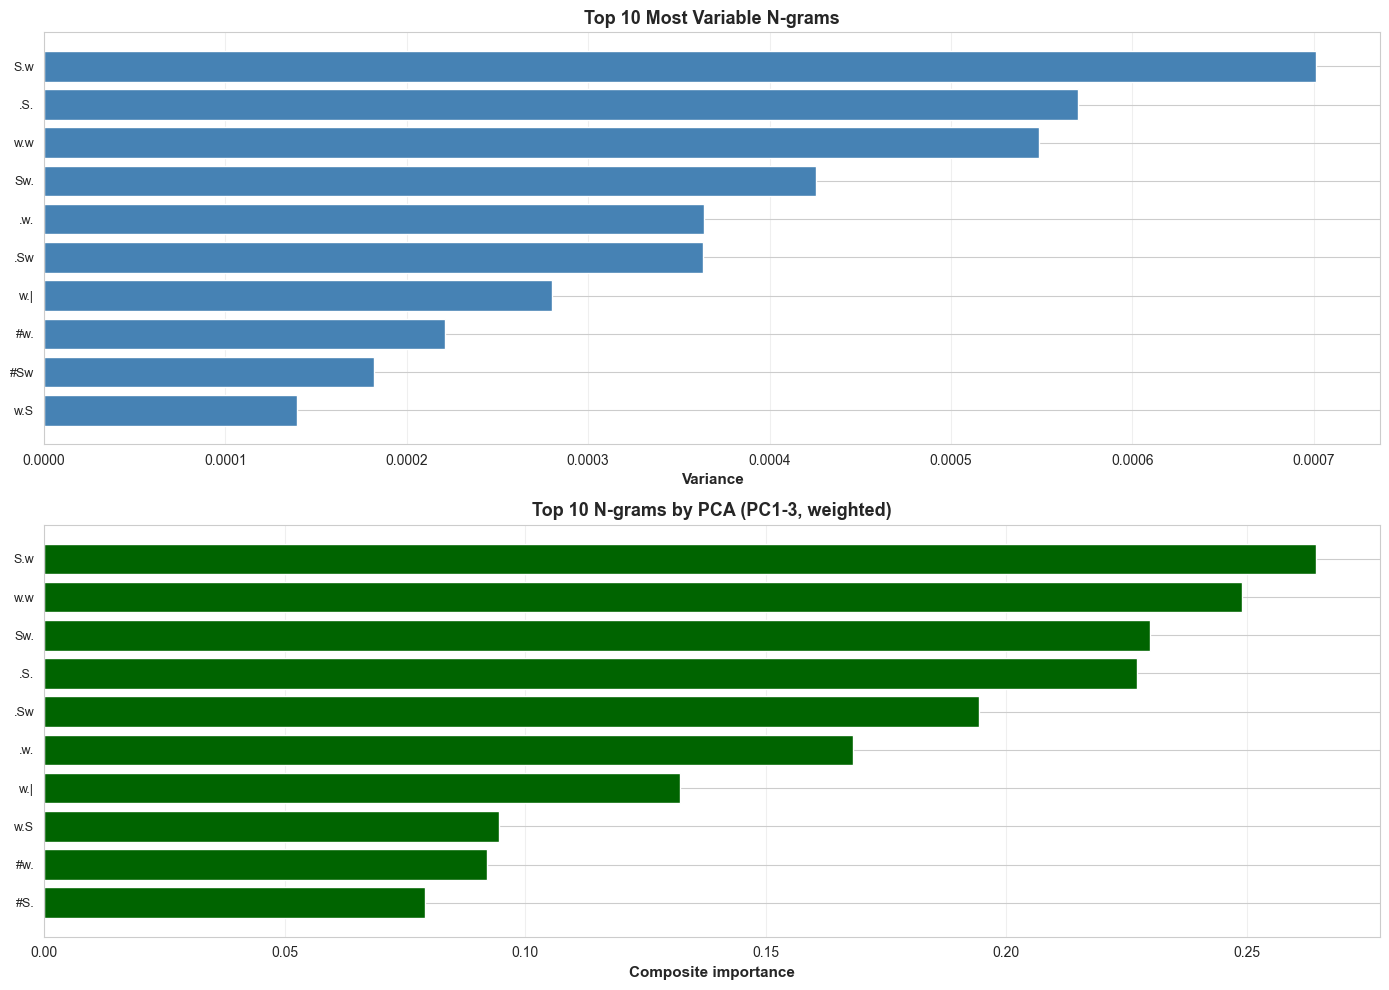

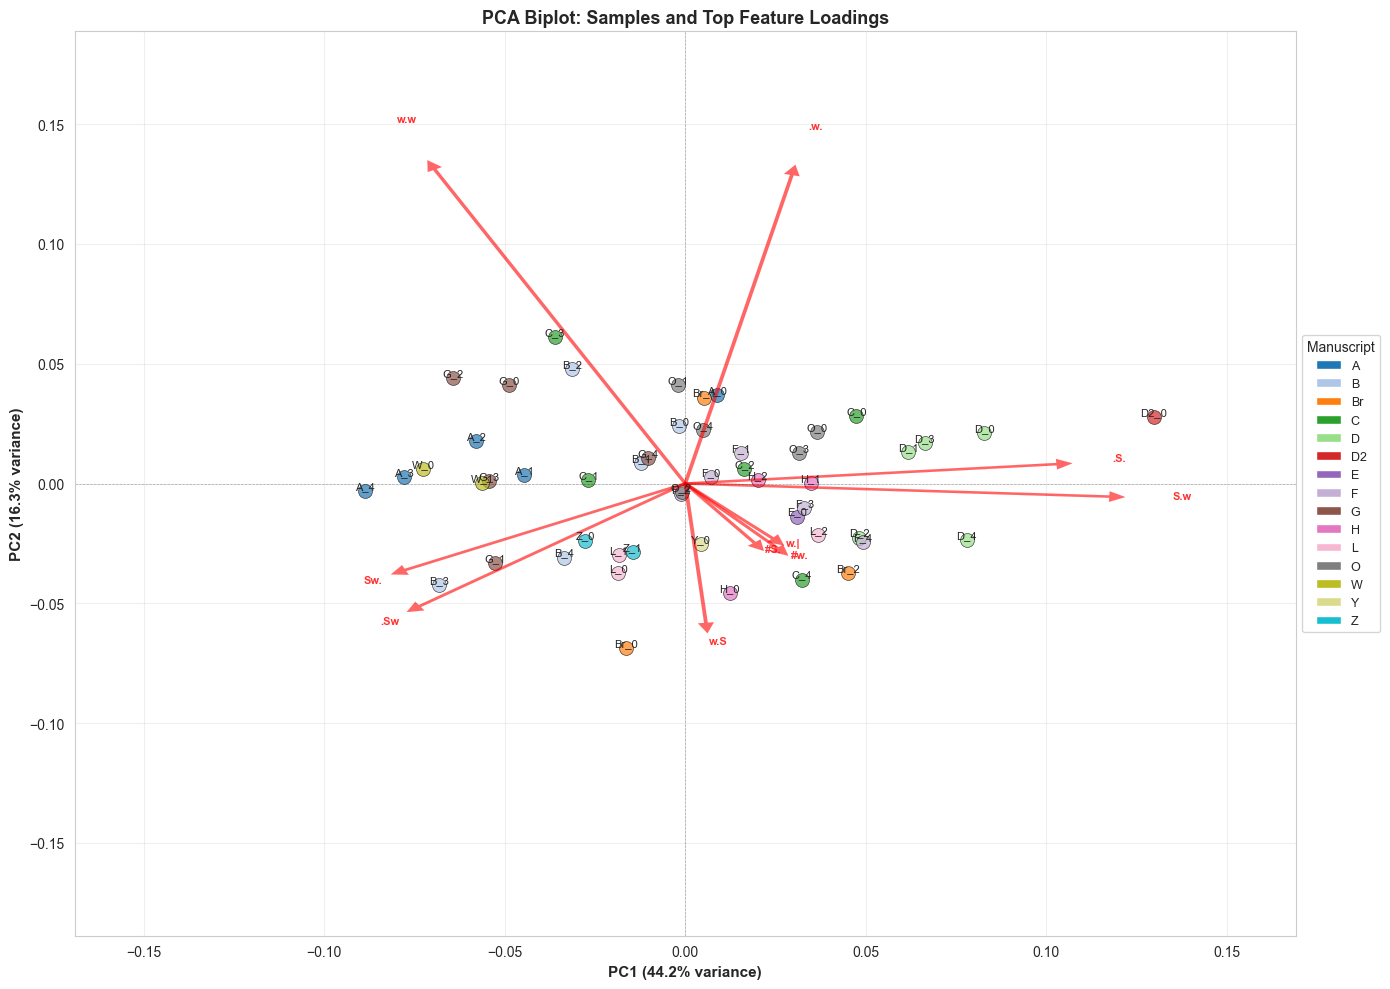

In [22]:
from sklearn.decomposition import PCA
import numpy as np

# check required variables
if 'X_normalized' not in globals() or 'kept_ngrams' not in globals():
    print("ERROR: variables not found")
else:
    print(f"\nAnalyzing {len(kept_ngrams)} features across {X_normalized.shape[0]} samples")
    
    # 1) variance-based ranking
    feature_variances = np.var(X_normalized, axis=0)
    variance_ranking = np.argsort(feature_variances)[::-1]
    
    # 2) PCA loading-based importance
    n_components = min(10, X_normalized.shape[0] - 1, X_normalized.shape[1])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_normalized)
    
    pc1_loadings = np.abs(pca.components_[0, :])
    pc2_loadings = np.abs(pca.components_[1, :])
    pc3_loadings = np.abs(pca.components_[2, :]) if n_components >= 3 else np.zeros(len(kept_ngrams))
    composite_importance = (
        pc1_loadings * pca.explained_variance_ratio_[0] +
        pc2_loadings * pca.explained_variance_ratio_[1] +
        (pc3_loadings * pca.explained_variance_ratio_[2] if n_components >= 3 else 0)
    )
    importance_ranking = np.argsort(composite_importance)[::-1]
    
    # Visualizations
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    top_n_viz = 10
    
    # variance
    n_to_plot_var = min(top_n_viz, len(variance_ranking))
    top_var_indices = variance_ranking[:n_to_plot_var]
    axes[0].barh(range(n_to_plot_var), feature_variances[top_var_indices], color='steelblue')
    axes[0].set_yticks(range(n_to_plot_var))
    axes[0].set_yticklabels([str(kept_ngrams[i])[:40] for i in top_var_indices], fontsize=9)
    axes[0].invert_yaxis()
    axes[0].set_title('Top 10 Most Variable N-grams', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Variance', fontsize=11, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # PCA importance
    n_to_plot_imp = min(top_n_viz, len(importance_ranking))
    top_imp_indices = importance_ranking[:n_to_plot_imp]
    axes[1].barh(range(n_to_plot_imp), composite_importance[top_imp_indices], color='darkgreen')
    axes[1].set_yticks(range(n_to_plot_imp))
    axes[1].set_yticklabels([str(kept_ngrams[i])[:40] for i in top_imp_indices], fontsize=9)
    axes[1].invert_yaxis()
    axes[1].set_title('Top 10 N-grams by PCA (PC1-3, weighted)', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Composite importance', fontsize=11, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    plt.tight_layout(); plt.show()
    
    # PCA biplot
    fig, ax = plt.subplots(figsize=(14, 10))
    ms_list = [s['ms'] for s in samples]
    unique_mss = sorted(set(ms_list))
    ms_colors = {ms: plt.cm.tab20(i / len(unique_mss)) for i, ms in enumerate(unique_mss)}
    for i, sample in enumerate(samples):
        ms = sample['ms']
        ax.scatter(X_pca[i, 0], X_pca[i, 1], c=[ms_colors[ms]], s=100, alpha=0.7,
                   edgecolors='black', linewidths=0.5)
        ax.text(X_pca[i, 0], X_pca[i, 1], sample_labels[i], fontsize=8, ha='center', va='bottom')
    
    # feature arrows (scaled to sample spread)
    top_features_for_biplot = min(10, len(importance_ranking))
    top_feature_indices = importance_ranking[:top_features_for_biplot]
    pc1_sample_range = X_pca[:, 0].max() - X_pca[:, 0].min()
    pc2_sample_range = X_pca[:, 1].max() - X_pca[:, 1].min()
    sample_range = max(pc1_sample_range, pc2_sample_range)
    max_loading_pc1 = np.max(np.abs(pca.components_[0, top_feature_indices]))
    max_loading_pc2 = np.max(np.abs(pca.components_[1, top_feature_indices]))
    max_loading = max(max_loading_pc1, max_loading_pc2)
    scale_factor = (sample_range * 0.6) / max_loading if max_loading > 0 and sample_range > 0 else 1.0
    for idx in top_feature_indices:
        pc1_loading = pca.components_[0, idx]
        pc2_loading = pca.components_[1, idx]
        ax.arrow(0, 0, pc1_loading * scale_factor, pc2_loading * scale_factor,
                 head_width=sample_range * 0.02, head_length=sample_range * 0.02,
                 fc='red', ec='red', alpha=0.6, linewidth=0.1)
        ax.text(pc1_loading * scale_factor * 1.15, pc2_loading * scale_factor * 1.15,
                str(kept_ngrams[idx])[:30], fontsize=8, color='red', fontweight='bold', alpha=0.8)
    
    # limits
    pc1_min = min(X_pca[:, 0].min(), -max_loading_pc1 * scale_factor * 1.2)
    pc1_max = max(X_pca[:, 0].max(),  max_loading_pc1 * scale_factor * 1.2)
    pc2_min = min(X_pca[:, 1].min(), -max_loading_pc2 * scale_factor * 1.2)
    pc2_max = max(X_pca[:, 1].max(),  max_loading_pc2 * scale_factor * 1.2)
    ax.set_xlim(*[pc1_min - (pc1_max-pc1_min)*0.1, pc1_max + (pc1_max-pc1_min)*0.1])
    ax.set_ylim(*[pc2_min - (pc2_max-pc2_min)*0.1, pc2_max + (pc2_max-pc2_min)*0.1])
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11, fontweight='bold')
    ax.set_title('PCA Biplot: Samples and Top Feature Loadings', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=0.5)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=ms_colors[ms], label=ms) for ms in unique_mss]
    ax.legend(handles=legend_elements, title='Manuscript', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
    plt.tight_layout(); plt.show()


### Step 4: Compute distances

Compute pairwise distances using the specified metric.


In [23]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import jensenshannon

def compute_distance_matrix(X, metric):
    """Compute pairwise distance matrix."""
    if metric == 'euclidean':
        D_condensed = pdist(X, metric='euclidean')
    elif metric == 'cosine':
        D_condensed = pdist(X, metric='cosine')
    elif metric == 'jsd':
        # Jensen-Shannon divergence (requires probability distributions)
        n = X.shape[0]
        D_condensed = []
        for i in range(n):
            for j in range(i+1, n):
                # JSD expects probability distributions (non-negative, sum to 1)
                p = np.maximum(X[i], 0)
                q = np.maximum(X[j], 0)
                p = p / (p.sum() + 1e-10)
                q = q / (q.sum() + 1e-10)
                jsd_val = jensenshannon(p, q)
                D_condensed.append(jsd_val)
        D_condensed = np.array(D_condensed)
    else:
        raise ValueError(f"Unknown DISTANCE_METRIC: {metric}")
    
    return D_condensed

# compute distances
print(f"computing distances with ({DISTANCE_METRIC})...")
D_condensed = compute_distance_matrix(X_normalized, DISTANCE_METRIC)
D = squareform(D_condensed)

print(f"  distance matrix: {D.shape}")
print(f"  distance range: [{D[D > 0].min():.4f}, {D.max():.4f}]")


computing distances with (cosine)...
  distance matrix: (51, 51)
  distance range: [0.0005, 0.0260]


In [24]:
# convert distance matrix to condensed form (required for linkage)
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
D_condensed = squareform(D, checks=False)

# Build hierarchical clustering tree (UPGMA = average linkage)
Z = linkage(D_condensed, method='average')

# compute cophenetic correlation (tree quality)
c, _ = cophenet(Z, D_condensed)

print(f"\nTree built (UPGMA)")
print(f"  Cophenetic correlation: {c:.3f}")
if c > 0.8:
    print("Data is tree-like")
elif c > 0.7:
    print("Some tree structure, but conflicting signals")
else:
    print("Data is not tree-like, consider networks or just MDS")


Tree built (UPGMA)
  Cophenetic correlation: 0.674
Data is not tree-like, consider networks or just MDS


### Bootstrap support analysis

To assess the reliability of tree branches, we perform bootstrap resampling of n-gram features:

**Method**: Resample n-gram features 200 times with replacement, rebuild the tree for each replicate, and track which splits (bipartitions) appear consistently across replicates.

**What we're testing**: Feature stability - "If we used different metrical features (n-grams), would the tree topology be the same?"

**Why resample features, not manuscripts?**
- We have a fixed set of manuscripts (not a sample from a population)
- We want to test if the clustering is robust to which features are used
- This is standard practice in phylogenetics, stylometry, and genomics

**Note on overlapping n-grams:**
- N-grams are overlapping and correlated (e.g., `(1,2,1)` contains `(1,2)` and `(2,1)`)
- This is expected and makes bootstrap MORE conservative (harder to get high support)
- High support means many different n-grams support the same clustering (robust pattern)
- Low support means the tree depends on specific n-grams (fragile pattern)

**Interpretation**:
- **Strong support (≥90%)**: Branch is very stable, based on a general metrical pattern
- **Moderate support (70-89%)**: Branch is reasonably stable  
- **Weak support (50-69%)**: Branch has limited support
- **Unreliable (<50%)**: Branch is not reproducible, should not be interpreted

Only branches with ≥70% support should be considered robust.


In [25]:
from collections import defaultdict
from scipy.cluster.hierarchy import to_tree
from sklearn.metrics import pairwise_distances

def get_bipartitions(Z, labels):
    """Extract all bipartitions (splits) from hierarchical tree."""
    tree = to_tree(Z)
    bipartitions = []
    
    def traverse(node):
        if node.is_leaf():
            return frozenset([labels[node.id]])
        
        left = traverse(node.left)
        right = traverse(node.right)
        
        # Non-trivial split (both sides have >1 leaf)
        if len(left) > 0 and len(right) > 0:
            # Store as tuple of frozensets (smaller first for consistency)
            split = tuple(sorted([left, right], key=len))
            bipartitions.append(split)
        
        return left | right
    
    traverse(tree)
    return bipartitions

# Bootstrap iterations
n_bootstrap = 200
bipartition_counts = defaultdict(int)

print(f"Running bootstrap analysis ({n_bootstrap} iterations)...")
for i in range(n_bootstrap):
    # Resample features (columns) with replacement
    boot_idx = np.random.choice(X_normalized.shape[1], 
                                 X_normalized.shape[1], 
                                 replace=True)
    X_boot = X_normalized[:, boot_idx]
    
    # Rebuild distance matrix and tree (use same routine as main analysis)
    D_boot_condensed = compute_distance_matrix(X_boot, DISTANCE_METRIC)
    # linkage expects condensed distances; do NOT squareform here
    Z_boot = linkage(D_boot_condensed, method='average')
    
    # Count bipartitions
    for bp in get_bipartitions(Z_boot, sample_labels):
        bipartition_counts[bp] += 1
    
    if (i+1) % 50 == 0:
        print(f"  {i+1}/{n_bootstrap} complete")

# calculate support for original tree
original_bipartitions = get_bipartitions(Z, sample_labels)
bootstrap_support = {}
for bp in original_bipartitions:
    support_pct = (bipartition_counts[bp] / n_bootstrap) * 100
    bootstrap_support[bp] = support_pct

# statistics
support_values = list(bootstrap_support.values())
if len(support_values) > 0:
    n_strong = sum(s >= 90 for s in support_values)
    n_moderate = sum(70 <= s < 90 for s in support_values)
    n_weak = sum(50 <= s < 70 for s in support_values)
    n_unreliable = sum(s < 50 for s in support_values)
    
    print(f"\nBootstrap support summary:")
    print(f"  Total internal branches: {len(support_values)}")
    print(f"  Strong support (≥90%): {n_strong} ({n_strong/len(support_values)*100:.1f}%)")
    print(f"  Moderate support (70-89%): {n_moderate} ({n_moderate/len(support_values)*100:.1f}%)")
    print(f"  Weak support (50-69%): {n_weak} ({n_weak/len(support_values)*100:.1f}%)")
    print(f"  Unreliable (<50%): {n_unreliable} ({n_unreliable/len(support_values)*100:.1f}%)")
    
    if n_unreliable > len(support_values) / 2:
        print("\nWARNING: More than half of branches have <50% support")
        print("  → Tree topology is unstable")
        print("  → Consider: different parameters, more data, or network methods")
    elif (n_strong + n_moderate) > len(support_values) / 2:
        print("\nMost branches have ≥70% support")
        print("  → Tree topology is relatively stable")
    else:
        print("\nMany branches have weak support")
        print("  → Interpret tree with caution")
else:
    print("\nNo internal branches found (tree has ≤2 samples)")

# Store for visualization
bootstrap_support_dict = bootstrap_support


Running bootstrap analysis (200 iterations)...
  50/200 complete
  100/200 complete
  150/200 complete
  200/200 complete

Bootstrap support summary:
  Total internal branches: 50
  Strong support (≥90%): 2 (4.0%)
  Moderate support (70-89%): 3 (6.0%)
  Weak support (50-69%): 5 (10.0%)
  Unreliable (<50%): 40 (80.0%)

  → Tree topology is unstable
  → Consider: different parameters, more data, or network methods


### Step 6: Tree visualization and optional ordinations

We now visualize the hierarchical relationships and the pairwise distance structure:
- Dendrogram with bootstrap support (primary, phylogeny-style view)
- Distance heatmap ordered by the tree (global structure)
- Optional: MDS ordination (2D embedding of distances; compare with PCA)


  Bipartitions: 49, Dendrogram branches: 50
  Expected: 50 (n_leaves=51)
  Some branches may not have support values displayed.


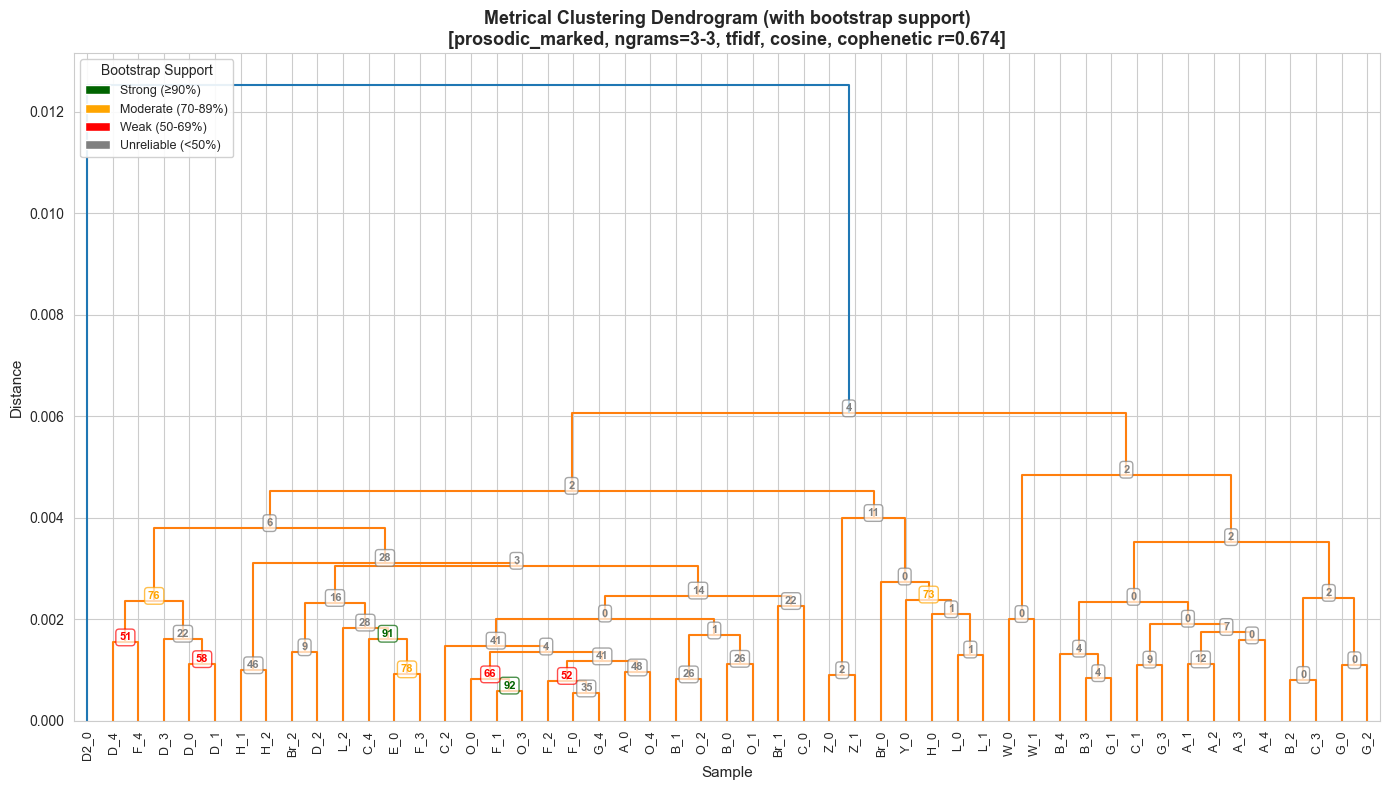

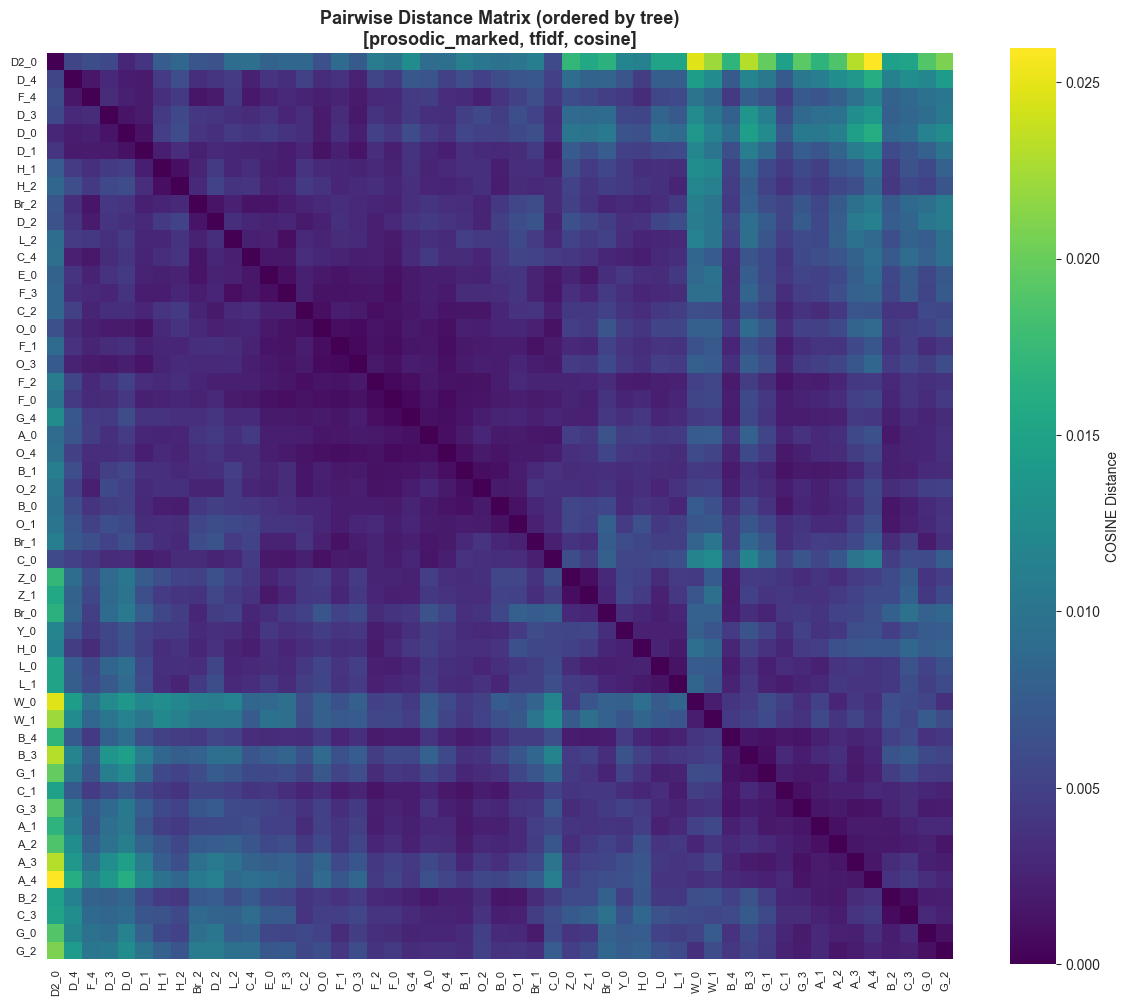

/Users/wouter/anaconda3/envs/mertens-metre-env/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


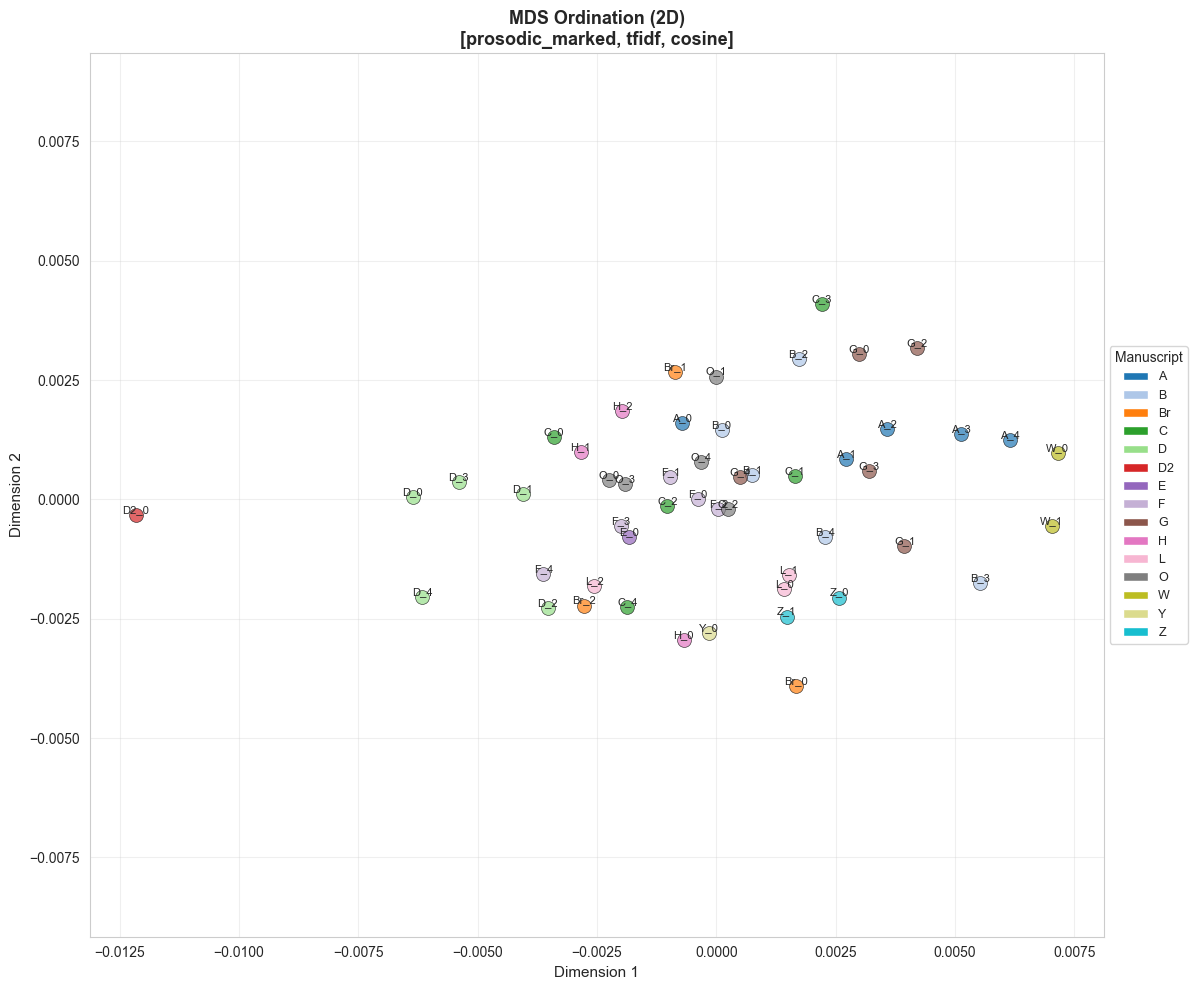

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS

# 1. Dendrogram with bootstrap support
fig, ax = plt.subplots(figsize=(14, 8))
dend = dendrogram(
    Z,
    labels=sample_labels,
    leaf_rotation=90,
    leaf_font_size=9,
    ax=ax
)

# Add bootstrap support values to branches
if bootstrap_support_dict:
    from scipy.cluster.hierarchy import to_tree
    
    # Extract bipartitions from linkage matrix in order (matching dendrogram branches)
    def get_bipartitions_in_linkage_order(Z, labels):
        """Extract bipartitions in the order they appear in the linkage matrix.
        
        Note: The dendrogram function preserves the merge order from the linkage matrix,
        so bipartitions extracted in this order should match the dendrogram branch order.
        """
        n_leaves = len(labels)
        bipartitions = []
        clusters = {i: {i} for i in range(n_leaves)}
        
        for i, (idx1, idx2, dist, count) in enumerate(Z):
            cluster1 = clusters[int(idx1)]
            cluster2 = clusters[int(idx2)]
            new_cluster = cluster1 | cluster2
            clusters[n_leaves + i] = new_cluster
            
            # Keep non-trivial splits (both sides have at least one leaf)
            # Note: We exclude the root split (where new_cluster contains all leaves)
            # because the dendrogram doesn't display the root as a separate branch.
            if len(cluster1) > 0 and len(cluster2) > 0 and len(new_cluster) < n_leaves:
                # Store as tuple of frozensets (sorted for consistency with get_bipartitions)
                split = tuple(sorted([frozenset([labels[j] for j in cluster1]), 
                                      frozenset([labels[j] for j in cluster2])], 
                                     key=len))
                bipartitions.append(split)
        
        return bipartitions
    
    # Get bipartitions in linkage order (matching dendrogram branch order)
    bipartitions_ordered = get_bipartitions_in_linkage_order(Z, sample_labels)
    
    # Match to dendrogram coordinates
    icoord = np.array(dend['icoord'])
    dcoord = np.array(dend['dcoord'])
    
    # Validation: Check that we have the expected number of branches
    # For n leaves, we expect n-1 internal branches (excluding root)
    n_leaves = len(sample_labels)
    expected_branches = n_leaves - 1
    n_bipartitions = len(bipartitions_ordered)
    n_dendro_branches = len(icoord)
    
    if n_bipartitions != n_dendro_branches:
        print(f"WARNING: Mismatch in branch counts!")
        print(f"  Bipartitions: {n_bipartitions}, Dendrogram branches: {n_dendro_branches}")
        print(f"  Expected: {expected_branches} (n_leaves={n_leaves})")
        print(f"  Some branches may not have support values displayed.")
    
    # Check how many bipartitions have support values
    n_with_support = sum(1 for bp in bipartitions_ordered if bp in bootstrap_support_dict)
    if n_with_support < len(bipartitions_ordered):
        print(f"Note: {n_with_support}/{len(bipartitions_ordered)} branches have bootstrap support values")
    
    # Annotate each internal branch
    for i, bp in enumerate(bipartitions_ordered):
        if i < len(icoord):
            # Look up support value for this bipartition
            support = bootstrap_support_dict.get(bp, None)
            
            if support is not None:
                # Branch midpoint
                x = (icoord[i, 1] + icoord[i, 2]) / 2
                y = dcoord[i, 1]
                
                # Color code by support level
                if support >= 90:
                    color = 'darkgreen'
                elif support >= 70:
                    color = 'orange'
                elif support >= 50:
                    color = 'red'
                else:
                    color = 'gray'
                
                # Add support percentage
                ax.text(x, y, f'{support:.0f}', 
                        fontsize=8, ha='center', va='bottom',
                        color=color, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                  edgecolor=color, alpha=0.7))
    
    # Add legend for support values
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='darkgreen', label='Strong (≥90%)'),
        Patch(facecolor='orange', label='Moderate (70-89%)'),
        Patch(facecolor='red', label='Weak (50-69%)'),
        Patch(facecolor='gray', label='Unreliable (<50%)')
    ]
    ax.legend(handles=legend_elements, loc='upper left', 
              title='Bootstrap Support', fontsize=9, framealpha=0.9)

ax.set_title(f'Metrical Clustering Dendrogram (with bootstrap support)\n'
             f'[{ENCODING}, ngrams={NGRAM_MIN}-{NGRAM_MAX}, {NORMALIZE}, {DISTANCE_METRIC}, cophenetic r={c:.3f}]',
             fontsize=13, fontweight='bold')
ax.set_ylabel('Distance', fontsize=11)
ax.set_xlabel('Sample', fontsize=11)
plt.tight_layout()
plt.show()

# 2. Distance heatmap (ordered by dendrogram)
fig, ax = plt.subplots(figsize=(12, 10))
leaf_order = dend['leaves']
D_ordered = D[np.ix_(leaf_order, leaf_order)]
labels_ordered = [sample_labels[i] for i in leaf_order]

sns.heatmap(D_ordered, 
            xticklabels=labels_ordered,
            yticklabels=labels_ordered,
            cmap='viridis',
            square=True,
            cbar_kws={'label': f'{DISTANCE_METRIC.upper()} Distance'},
            ax=ax)
ax.set_title(f'Pairwise Distance Matrix (ordered by tree)\n'
             f'[{ENCODING}, {NORMALIZE}, {DISTANCE_METRIC}]',
             fontsize=13, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# 3. MDS ordination
fig, ax = plt.subplots(figsize=(12, 10))
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=RNG_SEED)
X_mds = mds.fit_transform(D)

# Color by manuscript (not chunk)
ms_list = [s['ms'] for s in samples]
unique_mss = sorted(set(ms_list))
ms_colors = {ms: plt.cm.tab20(i / len(unique_mss)) for i, ms in enumerate(unique_mss)}

for i, sample in enumerate(samples):
    ms = sample['ms']
    ax.scatter(X_mds[i, 0], X_mds[i, 1], 
               c=[ms_colors[ms]], 
               s=100, 
               alpha=0.7,
               edgecolors='black',
               linewidths=0.5)
    ax.text(X_mds[i, 0], X_mds[i, 1], 
            sample_labels[i], 
            fontsize=8, 
            ha='center', 
            va='bottom')

ax.set_title(f'MDS Ordination (2D)\n'
             f'[{ENCODING}, {NORMALIZE}, {DISTANCE_METRIC}]',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Dimension 1', fontsize=11)
ax.set_ylabel('Dimension 2', fontsize=11)
ax.grid(alpha=0.3)
ax.axis('equal')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=ms_colors[ms], label=ms) for ms in unique_mss]
ax.legend(handles=legend_elements, 
          title='Manuscript',
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          fontsize=9)

plt.tight_layout()
plt.show()


### Manuscript-level dendrogram (centroid aggregation)
We collapse all chunks per manuscript by taking the feature-wise mean (centroid) per manuscript, then compute distances between manuscript centroids and build a dendrogram. This yields one branch per manuscript and complements the chunk-level tree.


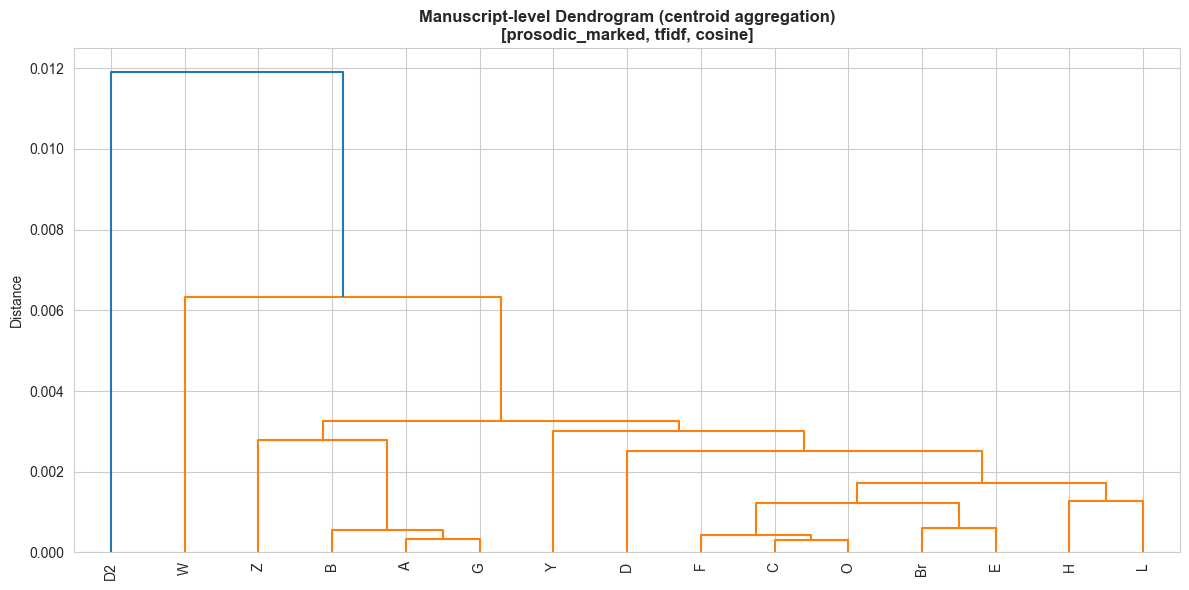

In [27]:
# manuscript-level tree via centroid aggregation
# group rows of X_normalized (chunks) by manuscript and average to centroids
import numpy as np
from collections import defaultdict
from scipy.cluster.hierarchy import linkage, dendrogram

# map manuscript -> list of row indices in X_normalized
ms_to_rows = defaultdict(list)
for i, sample in enumerate(samples):
    ms_to_rows[sample['ms']].append(i)

manuscripts = sorted(ms_to_rows.keys())
X_ms = np.vstack([
    X_normalized[ms_to_rows[ms], :].mean(axis=0) if len(ms_to_rows[ms]) > 0 else np.zeros(X_normalized.shape[1])
    for ms in manuscripts
])

# distances between manuscript centroids (condensed) and build tree
D_ms_condensed = compute_distance_matrix(X_ms, DISTANCE_METRIC)
Z_ms = linkage(D_ms_condensed, method='average')

# manuscript-level dendrogram
fig, ax = plt.subplots(figsize=(12, 6))
dendrogram(Z_ms, labels=manuscripts, leaf_rotation=90, leaf_font_size=10, ax=ax)
ax.set_title(f'Manuscript-level Dendrogram (centroid aggregation)\n[{ENCODING}, {NORMALIZE}, {DISTANCE_METRIC}]', fontsize=12, fontweight='bold')
ax.set_ylabel('Distance')
plt.tight_layout()
plt.show()


### Beat Count Stratification: separate trees for lines with different n of beats

If `BEAT_COUNT_FILTER='separate'`, we build separate trees for each beat count and compare them.

This removes the confound where ictus encoding implicitly encodes beat count through normalized positions.


In [28]:
if BEAT_COUNT_FILTER == 'separate':
    print("="*80)
    print("BEAT COUNT STRATIFICATION: BUILDING SEPARATE TREES")
    print("="*80)
    
    # Determine which beat counts to analyze
    beat_counts_available = sorted(encodings_df['beats'].unique())
    beat_counts_to_analyze = [bc for bc in beat_counts_available if bc in [2, 3, 4]]
    
    print(f"\nBeat counts to analyze: {beat_counts_to_analyze}")
    print(f"(Excluding beat counts < 2 or > 4)")
    
    # Store results for each beat count
    beat_count_results = {}
    
    for beat_count in beat_counts_to_analyze:
        print(f"\n{'='*80}")
        print(f"ANALYZING {beat_count}-BEAT LINES")
        print(f"{'='*80}")
        
        # Filter to this beat count
        beat_df = encodings_df[encodings_df['beats'] == beat_count].copy()
        
        # Check manuscript coverage
        ms_counts_beat = beat_df.groupby('ms').size()
        viable_mss_beat = ms_counts_beat[ms_counts_beat >= MIN_LINES].index.tolist()
        
        print(f"\nManuscripts with ≥{MIN_LINES} {beat_count}-beat lines: {len(viable_mss_beat)}")
        if len(viable_mss_beat) < 3:
            print(f"WARNING: Only {len(viable_mss_beat)} manuscripts have enough {beat_count}-beat lines")
            print(f"Skipping {beat_count}-beat analysis (need at least 3 manuscripts)")
            continue
        
        print(f"Coverage: {', '.join(viable_mss_beat)}")
        
        # Extract n-grams for this beat count
        samples_beat = []
        for ms in sorted(viable_mss_beat):
            ms_data = beat_df[beat_df['ms'] == ms].copy()
            ms_data = ms_data.sort_values('cumulative_line').reset_index(drop=True)
            
            # No chunking for simplicity in stratified analysis
            all_ngrams = []
            for _, row in ms_data.iterrows():
                encoding = extract_encoding(row, ENCODING, INCLUDE_TAIL)
                ngrams = generate_ngrams(encoding, NGRAM_MIN, NGRAM_MAX, ENCODING)
                all_ngrams.extend(ngrams)
            
            samples_beat.append({
                'ms': ms,
                'chunk_id': 0,
                'n_lines': len(ms_data),
                'ngrams': Counter(all_ngrams)
            })
        
        print(f"\nExtracted n-grams from {len(samples_beat)} manuscripts")
        
        # Build feature matrix
        ngram_df_counts_beat = Counter()
        for sample in samples_beat:
            for ngram in set(sample['ngrams'].keys()):
                ngram_df_counts_beat[ngram] += 1
        
        # Apply DF filtering
        kept_ngrams_beat = []
        for ngram, df in ngram_df_counts_beat.items():
            if df >= DF_MIN:
                if DF_MAX is None or df <= DF_MAX:
                    kept_ngrams_beat.append(ngram)
        
        kept_ngrams_beat = sorted(kept_ngrams_beat)
        
        print(f"Features after DF filtering: {len(kept_ngrams_beat)}")
        
        if len(kept_ngrams_beat) < 5:
            print(f"WARNING: Only {len(kept_ngrams_beat)} features for {beat_count}-beat lines")
            print(f"Skipping {beat_count}-beat analysis (need at least 5 features)")
            continue
        
        # Build raw matrix
        X_raw_beat = np.zeros((len(samples_beat), len(kept_ngrams_beat)))
        for i, sample in enumerate(samples_beat):
            for j, ngram in enumerate(kept_ngrams_beat):
                X_raw_beat[i, j] = sample['ngrams'].get(ngram, 0)
        
        # Normalize
        from sklearn.feature_extraction.text import TfidfTransformer
        if NORMALIZE == 'tfidf':
            transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
            X_norm_beat = transformer.fit_transform(X_raw_beat).toarray()
        elif NORMALIZE == 'l1':
            row_sums = X_raw_beat.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1
            X_norm_beat = X_raw_beat / row_sums
        elif NORMALIZE == 'zscore':
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_norm_beat = scaler.fit_transform(X_raw_beat)
        
        print(f"Normalized matrix: {X_norm_beat.shape}")
        
        # Build tree
        from sklearn.metrics import pairwise_distances
        from scipy.spatial.distance import squareform
        from scipy.cluster.hierarchy import linkage, cophenet
        
        D_beat = pairwise_distances(X_norm_beat, metric=DISTANCE_METRIC)
        D_beat_cond = squareform(D_beat, checks=False)
        Z_beat = linkage(D_beat_cond, method='average')
        
        # Metrics
        c_beat, _ = cophenet(Z_beat, D_beat_cond)
        
        print(f"Cophenetic correlation: {c_beat:.3f}")
        
        # Store results
        beat_count_results[beat_count] = {
            'samples': samples_beat,
            'X_normalized': X_norm_beat,
            'kept_ngrams': kept_ngrams_beat,
            'D': D_beat,
            'Z': Z_beat,
            'cophenetic_r': c_beat,
            'viable_mss': viable_mss_beat
        }
    
    # Compare trees
    print(f"\n{'='*80}")
    print("COMPARISON ACROSS BEAT COUNTS")
    print(f"{'='*80}")
    
    if len(beat_count_results) < 2:
        print("\nWARNING: Need at least 2 beat counts to compare")
    else:
        print(f"\nBuilt trees for {len(beat_count_results)} beat counts:")
        for bc, res in beat_count_results.items():
            print(f"  {bc}-beat: {len(res['samples'])} manuscripts, "
                  f"{len(res['kept_ngrams'])} features, cophenetic r={res['cophenetic_r']:.3f}")
        
        # Check manuscript overlap
        if len(beat_count_results) >= 2:
            beat_counts_list = list(beat_count_results.keys())
            for i in range(len(beat_counts_list)):
                for j in range(i+1, len(beat_counts_list)):
                    bc1, bc2 = beat_counts_list[i], beat_counts_list[j]
                    mss1 = set(beat_count_results[bc1]['viable_mss'])
                    mss2 = set(beat_count_results[bc2]['viable_mss'])
                    overlap = mss1 & mss2
                    print(f"\n{bc1}-beat vs {bc2}-beat:")
                    print(f"  Shared manuscripts: {len(overlap)} ({', '.join(sorted(overlap))})")
                    
                    if len(overlap) >= 3:
                        # Compare distances for shared manuscripts
                        # Extract distance submatrices for shared MSS
                        idx1 = [i for i, s in enumerate(beat_count_results[bc1]['samples']) if s['ms'] in overlap]
                        idx2 = [i for i, s in enumerate(beat_count_results[bc2]['samples']) if s['ms'] in overlap]
                        
                        D1_sub = beat_count_results[bc1]['D'][np.ix_(idx1, idx1)]
                        D2_sub = beat_count_results[bc2]['D'][np.ix_(idx2, idx2)]
                        
                        # Flatten upper triangles
                        triu_idx = np.triu_indices(len(overlap), k=1)
                        d1_vec = D1_sub[triu_idx]
                        d2_vec = D2_sub[triu_idx]
                        
                        # Correlation
                        corr = np.corrcoef(d1_vec, d2_vec)[0, 1]
                        print(f"  Distance correlation: {corr:.3f}")
                        
                        if corr > 0.7:
                            print(f"  → Strong agreement: manuscripts cluster similarly")
                        elif corr > 0.4:
                            print(f"  → Moderate agreement")
                        else:
                            print(f"  → Weak agreement: metrical style differs by beat count")

else:
    print("\nBEAT_COUNT_FILTER not set to 'separate', skipping stratified analysis")
    beat_count_results = {}  # Empty dict for consistency


BEAT COUNT STRATIFICATION: BUILDING SEPARATE TREES

Beat counts to analyze: [np.int64(2), np.int64(3), np.int64(4)]
(Excluding beat counts < 2 or > 4)

ANALYZING 2-BEAT LINES

Manuscripts with ≥100 2-beat lines: 0
Skipping 2-beat analysis (need at least 3 manuscripts)

ANALYZING 3-BEAT LINES

Manuscripts with ≥100 3-beat lines: 15
Coverage: A, B, Br, C, D, D2, E, F, G, H, L, O, W, Y, Z

Extracted n-grams from 15 manuscripts
Features after DF filtering: 35
Normalized matrix: (15, 35)
Cophenetic correlation: 0.928

ANALYZING 4-BEAT LINES

Manuscripts with ≥100 4-beat lines: 14
Coverage: A, B, Br, C, D, E, F, G, H, L, O, W, Y, Z

Extracted n-grams from 14 manuscripts
Features after DF filtering: 35
Normalized matrix: (14, 35)
Cophenetic correlation: 0.905

COMPARISON ACROSS BEAT COUNTS

Built trees for 2 beat counts:
  3-beat: 15 manuscripts, 35 features, cophenetic r=0.928
  4-beat: 14 manuscripts, 35 features, cophenetic r=0.905

3-beat vs 4-beat:
  Shared manuscripts: 14 (A, B, Br, C, 

Create a faceted plot showing dendrograms for each beat count side-by-side.


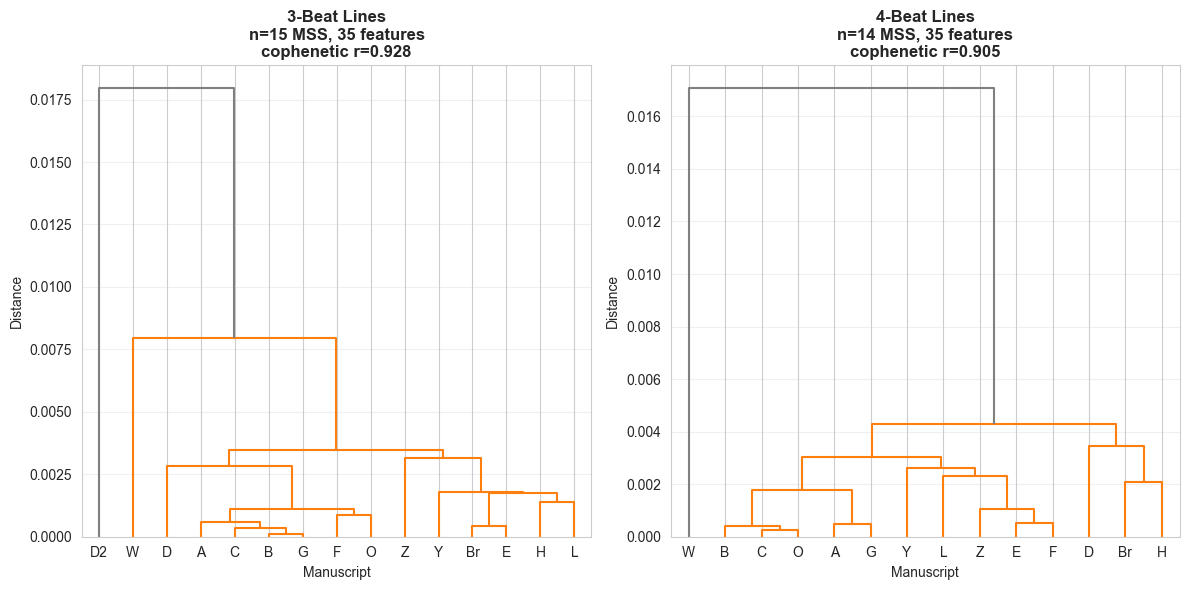

In [29]:
if beat_count_results:
    from scipy.cluster.hierarchy import dendrogram
    
    n_trees = len(beat_count_results)
    fig, axes = plt.subplots(1, n_trees, figsize=(6*n_trees, 6))
    
    # Handle single tree case
    if n_trees == 1:
        axes = [axes]
    
    for idx, (beat_count, res) in enumerate(sorted(beat_count_results.items())):
        ax = axes[idx]
        
        # Get labels
        labels = [s['ms'] for s in res['samples']]
        
        # Plot dendrogram
        dend = dendrogram(
            res['Z'],
            labels=labels,
            ax=ax,
            leaf_font_size=10,
            above_threshold_color='gray'
        )
        
        ax.set_title(f'{beat_count}-Beat Lines\n'
                     f'n={len(labels)} MSS, {len(res["kept_ngrams"])} features\n'
                     f'cophenetic r={res["cophenetic_r"]:.3f}',
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Manuscript', fontsize=10)
        ax.set_ylabel('Distance', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No beat count results to visualize (BEAT_COUNT_FILTER not set to 'separate')")


### Distance Correlation Heatmap

Visualize how similar the distance matrices are across beat counts.


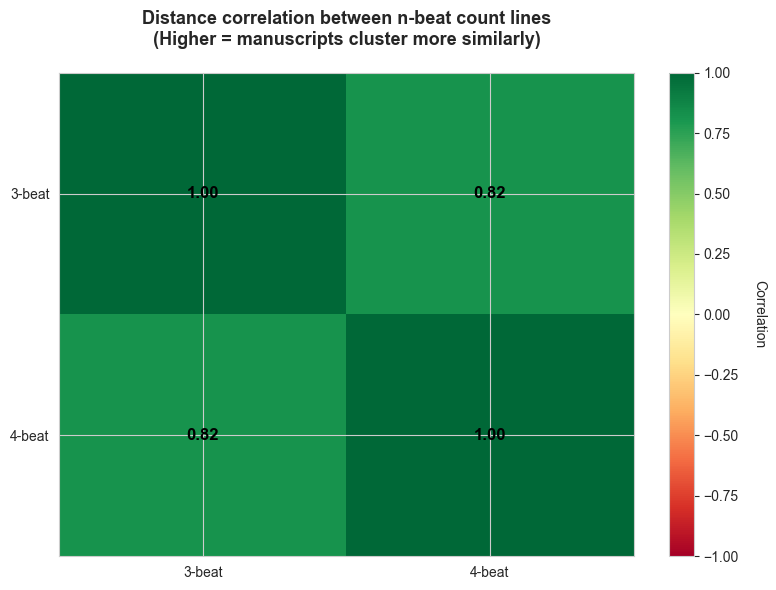

In [30]:
if len(beat_count_results) >= 2:
    # correlation matrix
    beat_counts_list = sorted(beat_count_results.keys())
    n_bc = len(beat_counts_list)
    corr_matrix = np.ones((n_bc, n_bc))
    
    for i in range(n_bc):
        for j in range(i+1, n_bc):
            bc1, bc2 = beat_counts_list[i], beat_counts_list[j]
            
            # Find shared manuscripts
            mss1 = set(beat_count_results[bc1]['viable_mss'])
            mss2 = set(beat_count_results[bc2]['viable_mss'])
            overlap = mss1 & mss2
            
            if len(overlap) >= 3:
                # Extract distance submatrices
                idx1 = [k for k, s in enumerate(beat_count_results[bc1]['samples']) if s['ms'] in overlap]
                idx2 = [k for k, s in enumerate(beat_count_results[bc2]['samples']) if s['ms'] in overlap]
                
                D1_sub = beat_count_results[bc1]['D'][np.ix_(idx1, idx1)]
                D2_sub = beat_count_results[bc2]['D'][np.ix_(idx2, idx2)]
                
                # Flatten upper triangles
                triu_idx = np.triu_indices(len(overlap), k=1)
                d1_vec = D1_sub[triu_idx]
                d2_vec = D2_sub[triu_idx]
                
                # Correlation
                corr = np.corrcoef(d1_vec, d2_vec)[0, 1]
                corr_matrix[i, j] = corr
                corr_matrix[j, i] = corr
    
    # heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    
    im = ax.imshow(corr_matrix, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
    
    # ticks
    ax.set_xticks(range(n_bc))
    ax.set_yticks(range(n_bc))
    ax.set_xticklabels([f'{bc}-beat' for bc in beat_counts_list])
    ax.set_yticklabels([f'{bc}-beat' for bc in beat_counts_list])
    
    # annotate cells
    for i in range(n_bc):
        for j in range(n_bc):
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=12, fontweight='bold')
    
    ax.set_title('Distance correlation between n-beat count lines\n'
                 '(Higher = manuscripts cluster more similarly)',
                 fontsize=13, fontweight='bold', pad=20)
    
    # colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
